The Vehicle Model has a python class to be instantized with hardpoints and vehicle properties

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy import integrate
from scipy.optimize import minimize, NonlinearConstraint
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
from openpyxl import load_workbook

In [2]:
class Vehicle:
    
    """The Vehicle class encapsulates a variety of methods and properties related to vehicle dynamics, steering, wheel loads, and geometric calculations.
     It leverages numerical methods, regressions, and physical equations to model and analyze vehicle behavior under different conditions.
     The class is designed to provide comprehensive insights into the performance and characteristics of a vehicle's steering and suspension systems.
    """
    # --- Constuctor for Inputs ---

    def __init__(self,    
             r_A: np.array,
             r_B: np.array,
             r_C: np.array,
             r_O: np.array,
             r_K: np.array,
             slr: float,
             dlr: float,
             initial_camber: float,
             toe_in: float,
             tw: float,
             wb: float,
             GVW: float,
             b: float,
             CG_height: float,
             wheel_rate_f: float,
             wheel_rate_r: float,
             tire_stiffness_f: float,
             tire_stiffness_r: float,
             pinion: float,
             tirep: float,
             dila: float,
             r_La: np.array,
             r_Lb: np.array,
             r_strut: np.array = np.array([0, 0, 0]),
             r_Ua: np.array = np.array([0, 0, 0]),
             r_Ub: np.array = np.array([0, 0, 0]),
             mu : float = 0.4,
             g : float = 9.8,
             speed: float = 10.0,
             linkage_effort: float = 1.36, # Nm
             linkage_kpm: float = 8.16, # Nm
             tiredata: np.array =  np.array([0.5094636099593582, 0.1120749440478134, 17.8337673155644, 0.4054933824758519, 0.25184969239087557, 5.904032519832173, 0.5968391994177625, 0.309857379732586 ]),
             CF_Loads: np.array = np.array([0, 150, 200, 250, 500]),
             CF_Stiffnessrad: np.array = np.array([0, 20234.57749,	23031.75745, 24629.16378, 24629.16378 + 250*(24629.16378-23031.75745)/50]),
             CF_pneumatictrail: np.array = np.array([0, 0.011909253,	0.018484467, 0.023331694, 0.023331694 + 250*(0.023331694-0.018484467)/50])): # Continental R13

        # Create static object
        # ulr - (ulr-slr)/load_rating

        self.static = Vehicle.create_object(r_A, r_B, r_C, r_O, r_K, slr, initial_camber, toe_in, tw, wb, GVW, b, 
                                          CG_height, wheel_rate_f, wheel_rate_r, tire_stiffness_f, tire_stiffness_r,
                                          pinion, tirep, dila, r_La, r_Lb, r_strut, r_Ua, r_Ub, mu, g, tiredata, speed)

        # Create dynamic object 
        self.dynamic = Vehicle.create_object(r_A, r_B, r_C, r_O, r_K, dlr, initial_camber, toe_in, tw, wb, GVW, b,
                                           CG_height, wheel_rate_f, wheel_rate_r, tire_stiffness_f, tire_stiffness_r,
                                           pinion, tirep, dila, r_La, r_Lb, r_strut, r_Ua, r_Ub, mu, g, tiredata, speed)
        # Initialize common parameters
        self.CF_Loads = CF_Loads
        self.CF_Stiffnessrad = CF_Stiffnessrad
        self.CF_pneumatictrail = CF_pneumatictrail
        self.dynamic_analysis = 1
        self.model = self.regression_model()
        reference = self.reference()
        self.dynamic_analysis = 0
        self.model = self.regression_model()
        self.rack_stroke = self.rack_vs_road_steer(reference.dila - toe_in)
        self.trainslipangles()
        self.linkage_friction_contribution_on_kpm = linkage_kpm
        self.linkage_friction_contribution_on_steering = linkage_effort   
    @classmethod
    def create_object(cls, r_A, r_B, r_C, r_O, r_K, tire_radius, initial_camber, toe_in, tw, wb, GVW, b, CG_height, 
                    wheel_rate_f, wheel_rate_r, tire_stiffness_f, tire_stiffness_r, pinion, tirep, dila,
                    r_La, r_Lb, r_strut, r_Ua, r_Ub, mu, g, tiredata,speed):
        
        obj = type('VehicleState', (), {})()
        
        # Assign instance variables
        obj.mu = mu
        obj.g = g
        obj.r_A = r_A
        obj.r_B = r_B 
        obj.r_C = r_C
        obj.r_O = r_O
        obj.r_K = r_K
        obj.tire_radius = tire_radius
        obj.initial_camber = initial_camber
        obj.tw = tw
        obj.wb = wb
        obj.GVW = GVW
        obj.b = b
        obj.a = wb - b
        obj.Kf = wheel_rate_f * tire_stiffness_f / (wheel_rate_f + tire_stiffness_f)
        obj.Kr = wheel_rate_r * tire_stiffness_r / (wheel_rate_r + tire_stiffness_r)
        obj.tiredata = tiredata
        obj.pinion = pinion
        obj.tirep = tirep
        obj.dila = dila
        obj.r_La = r_La
        obj.r_Lb = r_Lb
        obj.r_strut = r_strut
        obj.r_Ua = r_Ua
        obj.r_Ub = r_Ub

        # Calculate additional points
        obj.r_D = np.array([obj.r_C[0], 0.00, obj.r_C[2]])
        obj.r_T = np.array([obj.r_O[0], obj.r_O[1] - obj.tire_radius * np.sin(np.radians(obj.initial_camber)),
                            obj.r_O[2] - obj.tire_radius])
        obj.r_O[2] = obj.r_O[2] - obj.tire_radius + obj.tire_radius * np.cos(np.radians(obj.initial_camber))
        obj.r_W = obj.r_T - np.array([np.cos(np.radians(toe_in)), np.sin(np.radians(toe_in)), 0])

        # Calculate KPA
        obj.KPA = (r_A - r_K) / cls.magnitude(r_A - r_K)
        obj.currKPA = (r_A - r_K) / cls.magnitude(r_A - r_K)

        # Initialize arrays
        obj.mindp = 50
        obj.maxdp = 50
        obj.step = 0.1
        obj.dpK = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpT = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpO = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpW = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpA = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpB = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpnewB = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpC = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpdz = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1)))
        obj.dpfvsa = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.dpsvsa = np.zeros((int(obj.mindp / obj.step + obj.maxdp / obj.step + 1), 3))
        obj.zeropos = int(obj.mindp / obj.step)

        # Set initial positions
        obj.dpK[obj.zeropos] = obj.r_K
        obj.dpO[obj.zeropos] = obj.r_O  
        obj.dpT[obj.zeropos] = obj.r_T
        obj.dpW[obj.zeropos] = obj.r_W
        obj.dpA[obj.zeropos] = obj.r_A
        obj.dpB[obj.zeropos] = obj.r_B
        obj.dpnewB[obj.zeropos] = obj.r_B
        obj.dpC[obj.zeropos] = obj.r_C
        obj.dpdz[obj.zeropos] = 0

        # Calculate angles
        h1 = (obj.KPA - np.dot(obj.KPA, np.array([0, 1, 0])) * np.array([0, 1, 0])) / cls.magnitude(
            obj.KPA - np.dot(obj.KPA, np.array([0, 1, 0])) * np.array([0, 1, 0]))
        h2 = (obj.KPA - np.dot(obj.KPA, np.array([1, 0, 0])) * np.array([1, 0, 0])) / cls.magnitude(
            obj.KPA - np.dot(obj.KPA, np.array([1, 0, 0])) * np.array([1, 0, 0]))
        obj.caster = np.degrees(np.arccos(np.dot(h1, np.array([0, 0, 1]))))
        obj.kpi = np.degrees(np.arccos(np.dot(h2, np.array([0, 0, 1]))))

        # Calculate projection points
        t = (obj.r_T[2] - obj.r_K[2]) / obj.KPA[2]
        obj.r_I = obj.r_K + t * obj.KPA
        obj.r_Aprime = cls.projection(obj.r_A, obj.KPA, obj.r_B)
        obj.r_Iprime = cls.projection(obj.r_A, obj.KPA, obj.r_T)
        obj.r_Iwprime = cls.projection(obj.r_A, obj.KPA, obj.r_W)
        obj.r_Ioprime = cls.projection(obj.r_A, obj.KPA, obj.r_O)

        obj.maxdecimal = int(-np.log10(obj.step))
        obj.conversionstep = int(10**obj.maxdecimal)
        # Initializing additional helper variables and methods
        
        obj.speed = speed*5/18 #m/s
        obj.CG_height = CG_height
        obj.slipangles = np.zeros((50, 2))
        obj.slipangles[0] = np.array([0.0,0.0])
        obj.Flguess = np.zeros((50))
        obj.Frguess = np.zeros((50))
        obj.Rlguess = np.zeros((50))
        obj.Rrguess = np.zeros((50))
        obj.Flguess[0] = obj.GVW*obj.b/(obj.a+obj.b)*0.5
        obj.Frguess[0] = obj.GVW*obj.b/(obj.a+obj.b)*0.5
        obj.Rlguess[0] = obj.GVW*obj.a/(obj.a+obj.b)*0.5
        obj.Rrguess[0] = obj.GVW*obj.a/(obj.a+obj.b)*0.5
        obj.patch_radius_left = 0
        obj.patch_radius_right = 0
        obj.tempdynamicsolution = np.zeros(12)
        obj.tempdynamictheta = 0


        return obj        
    def reference(self):
        if(self.dynamic_analysis == 0):
            reference = self.static
        else:
            reference = self.dynamic
        return reference
    # --- Calculation of instantaneous axis for suspension travel ---
    def fvsa_equations(self, values):
        """
        Calculates the equations for Front View Swing Arm (FVSA) optimization.

        Computes the difference between two vectors based on vehicle geometry and steering parameters
        to find optimal values of `la` and `mu`. Depending on whether `r_strut` is defined, calculates
        equations for suspension parameters affecting FVSA optimization.

        Args:
        values (list or tuple): Contains two float values representing:
            - `la`: Parameter affecting the vector calculation based on current_A and current_K.
            - `mu`: Parameter affecting the vector calculation based on current_K and average of r_La and r_Lb.

        Returns:
        list: A list containing two equations (`eq1` and `eq2`) representing the difference between `l2` and `l1`.
            - `eq1`: Difference in the y-component between `l2` and `l1`.
            - `eq2`: Difference in the z-component between `l2` and `l1`.

        Notes:
        - If `r_strut` is not defined (equal to [0, 0, 0]), calculates `a2` based on average of r_Ua and r_Ub.
        - If `r_strut` is defined, calculates `a2` based on current_A and cross product of r_strut-a1 and [1, 0, 0].
        - `current_A`, `current_K`, and `current_O` are calculated using `self.curr_A`, `self.curr_K`, and `self.curr_O`
        methods respectively, with `self.curr_KPA_angle_for_fvsa` as input.
        """
        reference = self.reference()
        if(reference.r_strut[0] == 0):
            la = values[0]
            mu = values[1]
            current_A = self.curr_A(self.curr_KPA_angle_for_fvsa)
            current_K = self.curr_K(self.curr_KPA_angle_for_fvsa)
            if reference.r_strut[0] == 0:
                # No strut present
                if(np.abs(reference.r_Ua[0] - reference.r_Ub[0])<1 and np.abs(reference.r_Ua[2] - reference.r_Ub[2])<1) :
                    a1 = reference.r_Ua
                    a2 = reference.r_Ub
                    b1 = reference.r_La
                    b2 = reference.r_Lb
                    l1 = a1 + la * (a1 - a2)
                    l2 = b1 + mu * (b1 - b2)
                else:
                    a1 = current_A
                    a2 = (reference.r_Ua + reference.r_Ub) / 2
                    b1 = current_K
                    b2 = (reference.r_La + reference.r_Lb) / 2
                    l1 = a1 + la * (a1 - a2)
                    l2 = b1 + mu * (b1 - b2)  
            l1 = a1 + la*(a1-a2)
            l2 = b1 + mu*(b1-b2)
            eq1 = (l2-l1)[1]
            eq2 = (l2-l1)[2]
        else:
            la = values[0]
            mu = values[1]
            current_A = self.curr_A(self.curr_KPA_angle_for_fvsa)
            current_K = self.curr_K(self.curr_KPA_angle_for_fvsa)
            current_O = self.curr_O(self.curr_KPA_angle_for_fvsa)
            a1 = current_A
            a2 = a1+np.cross(reference.r_strut-a1, np.array([1,0,0]))
            b1 = current_K
            b2 = (reference.r_La+reference.r_Lb)/2
            a2 += 1e-9
            b2 += 1e-9
            l1 = a1 + la*(a1-a2)
            l2 = b1 + mu*(b1-b2)
            eq1 = (l2-l1)[1]
            eq2 = (l2-l1)[2]
        return [eq1,eq2]
    def fvsa_ic(self, curr_KPA_angle):
        """
        Computes the Instantaneous Centers (IC) for the Front View Swing Arm (FVSA) suspension.

        This method calculates the IC based on the current KPA angle and the geometry of the suspension.

        Args:
        curr_KPA_angle (float): Current Kingpin Axis (KPA) angle in degrees.

        Returns:
        ndarray: Coordinates of the Instantaneous Center (IC) in 3D space.

        Notes:
        - Uses numerical root-finding (fsolve) to staticsolve the FVSA equations for la and mu.
        - Handles different configurations based on the presence of a strut.
        """
        reference = self.reference()
        self.curr_KPA_angle_for_fvsa = curr_KPA_angle
        position_to_add = reference.zeropos + int(np.round(curr_KPA_angle, reference.maxdecimal) * reference.conversionstep)
        if(np.abs(reference.dpfvsa[position_to_add][0])>np.abs(reference.dpfvsa[reference.zeropos][0]/10000)):
            return reference.dpfvsa[position_to_add]
        if reference.r_strut[0] == 0:
            # No strut present
            
            current_A = self.curr_A(curr_KPA_angle)
            current_K = self.curr_K(curr_KPA_angle)
            if(np.abs(reference.r_Ua[0] - reference.r_Ub[0])<1 and np.abs(reference.r_Ua[2] - reference.r_Ub[2])<1) :
                reference.dpfvsa[position_to_add] = self.svsa_ic(curr_KPA_angle) + np.array([0,1,0])
                return reference.dpfvsa[position_to_add]
            else:
                la, mu = fsolve(self.fvsa_equations, [0.01, 0.01])
                a1 = current_A
                a2 = (reference.r_Ua + reference.r_Ub) / 2
                b1 = current_K
                b2 = (reference.r_La + reference.r_Lb) / 2
                l1 = a1 + la * (a1 - a2)
                l2 = b1 + mu * (b1 - b2)   
        else:
            # Strut present
            la, mu = fsolve(self.fvsa_equations, [0.01, 0.01])
            current_A = self.curr_A(curr_KPA_angle)
            current_K = self.curr_K(curr_KPA_angle)
            current_O = self.curr_O(curr_KPA_angle)
            a1 = current_A
            a2 = a1 + np.cross(reference.r_strut - a1, np.array([1, 0, 0]))
            b1 = current_K
            b2 = (reference.r_La + reference.r_Lb) / 2
            l1 = a1 + la * (a1 - a2)
            l2 = b1 + mu * (b1 - b2)
        reference.dpfvsa[position_to_add] = (l1 + l2) / 2

        return reference.dpfvsa[position_to_add]
    def svsa_equations(self, values):
        """
        Calculates the Side View Swing Arm (SVSA) suspension equations for finding la and mu.

        This method computes the equations based on the current configuration of the suspension.
        For configurations without a strut, it uses the upper (Ua, Ub) and lower (La, Lb) control arm pivot points.
        For configurations with a strut, it adjusts the calculation based on the strut position relative to the upper pivot.

        Args:
        values (list): List containing la and mu values to staticsolve the equations.

        Returns:
        list: Equations [eq1, eq2] representing the difference between computed lengths l2 and l1 along x and z axes.

        Notes:
        - Uses current KPA angle for calculating current_A.
        - Handles different suspension configurations based on the presence of a strut (r_strut).
        """
        reference = self.reference()
        if reference.r_strut[0] == 0:
            la = values[0]
            mu = values[1]
            # No strut present
            current_A = self.curr_A(self.curr_KPA_angle_for_svsa)
            current_K = self.curr_K(self.curr_KPA_angle_for_svsa)
            if(np.abs(reference.r_Ua[0] - reference.r_Ub[0])<1 and np.abs(reference.r_Ua[2] - reference.r_Ub[2])<1) :
                a1 = current_A
                a2 = (reference.r_Ua + reference.r_Ub) / 2
                b1 = current_K
                b2 = (reference.r_La + reference.r_Lb) / 2
                l1 = a1 + la * (a1 - a2)
                l2 = b1 + mu * (b1 - b2)
            else:
                a1 = reference.r_Ua
                a2 = reference.r_Ub
                b1 = reference.r_La
                b2 = reference.r_Lb
                l1 = a1 + la * (a1 - a2)
                l2 = b1 + mu * (b1 - b2)
            eq1 = (l2 - l1)[0]
            eq2 = (l2 - l1)[2]
        else:
            # Strut present
            la = values[0]
            mu = values[1]
            current_A = self.curr_A(self.curr_KPA_angle_for_svsa)
            a1 = current_A
            a2 = a1 + np.cross(reference.r_strut - a1, np.array([0, 1, 0]))
            b1 = reference.r_La
            b2 = reference.r_Lb
            a2 += 1e-9
            b2 += 1e-9
            l1 = a1 + la * (a1 - a2)
            l2 = b1 + mu * (b1 - b2)
            eq1 = (l2 - l1)[0]
            eq2 = (l2 - l1)[2]
        
        return [eq1, eq2]
    def svsa_ic(self, curr_KPA_angle):
        """
        Computes the Instantaneous Centers (IC) for the Side View Swing Arm (SVSA) suspension.

        This method calculates the IC based on the current configuration of the SVSA suspension.
        If no strut is present, it uses the upper (Ua, Ub) and lower (La, Lb) control arm pivot points.
        If a strut is present, it adjusts the calculation based on the strut position relative to the upper pivot.

        Args:
        curr_KPA_angle (float): Current Kingpin Axis (KPA) angle in radians.

        Returns:
        ndarray: Coordinates of the IC (Instantaneous Center) calculated as the midpoint of lengths l1 and l2.

        Notes:
        - Uses fsolve to staticsolve the svsa_equations for la and mu.
        - Handles different suspension configurations based on the presence of a strut (r_strut).
        """
        reference = self.reference()
        self.curr_KPA_angle_for_svsa = curr_KPA_angle
        position_to_add = reference.zeropos + int(np.round(curr_KPA_angle, reference.maxdecimal) * reference.conversionstep)
        if(reference.dpsvsa[position_to_add][0]>reference.dpsvsa[reference.zeropos][0]/10):
            return reference.dpsvsa[position_to_add]
        if reference.r_strut[0] == 0:
            # No strut present            
            [la, mu] = fsolve(self.svsa_equations, [0.01, 0.01])
            current_A = self.curr_A(self.curr_KPA_angle_for_svsa)
            current_K = self.curr_K(curr_KPA_angle)
            if(np.abs(reference.r_Ua[0] - reference.r_Ub[0])<1 and np.abs(reference.r_Ua[2] - reference.r_Ub[2])<1) :
                a1 = current_A
                a2 = (reference.r_Ua + reference.r_Ub) / 2
                b1 = current_K
                b2 = (reference.r_La + reference.r_Lb) / 2
                l1 = a1 + la * (a1 - a2)
                l2 = b1 + mu * (b1 - b2)
            else:
                a1 = reference.r_Ua
                a2 = reference.r_Ub
                b1 = reference.r_La
                b2 = reference.r_Lb
                l1 = a1 + la * (a1 - a2)
                l2 = b1 + mu * (b1 - b2)
        else:
            # Strut present
            [la, mu] = fsolve(self.svsa_equations, [0.01, 0.01])
            current_A = self.curr_A(self.curr_KPA_angle_for_svsa)
            a1 = current_A
            a2 = a1 + np.cross(reference.r_strut - a1, np.array([0, 1, 0]))
            b1 = reference.r_La
            b2 = reference.r_Lb
            l1 = a1 + la * (a1 - a2)
            l2 = b1 + mu * (b1 - b2)
        reference.dpsvsa[position_to_add] = (l1 + l2) / 2
        
        return reference.dpsvsa[position_to_add]
    def solveK(self, inputval):
        """
        Solves for the position of point K along the suspension axis.

        This method calculates the position of point K based on the input value `t` and the current configuration
        of the suspension. It uses the current orientation and positions of points O, K, and the instantaneous
        centers (ICs) for the FVSA and SVSA suspensions.

        Args:
        inputval (list): Input value `t` as a list where `t = [t_val]`.

        Returns:
        list: A list containing the staticequation `eq1`, representing the error between the current and previous delta_z values
            and the difference between `tempK` and the stored position of K.

        Notes:
        - Uses the current KPA angle (`curr_KPA_angle_for_K`) to calculate positions and orientations.
        - Adjusts positions based on the sign of `curr_KPA_angle_for_K`.
        - Utilizes rotational transformations and delta_z calculations for accuracy.
        """
        reference = self.reference()
        t = inputval[0]
        tempO = self.curr_O(self.curr_KPA_angle_for_K)
        position_to_add = reference.zeropos + int(np.round(self.curr_KPA_angle_for_K, reference.maxdecimal) * reference.conversionstep)
        tempK = Vehicle.rotation(reference.dpK[position_to_add - int(np.sign(self.curr_KPA_angle_for_K))].tolist(),
                                self.fvsa_ic(self.curr_KPA_angle_for_K - np.sign(self.curr_KPA_angle_for_K) * reference.step).tolist(),
                                self.svsa_ic(self.curr_KPA_angle_for_K - np.sign(self.curr_KPA_angle_for_K) * reference.step).tolist(), t)
        eq1 = self.delta_z(self.curr_KPA_angle_for_K) - self.delta_z(self.curr_KPA_angle_for_K - reference.step * np.sign(self.curr_KPA_angle_for_K)) + (tempK - reference.dpK[position_to_add - int(np.sign(self.curr_KPA_angle_for_K))])[2]
        return [eq1]
    def curr_K(self, curr_KPA_angle):
        """
        Computes the position of point K based on the current KPA angle.

        This method calculates the position of point K along the suspension axis based on the provided current
        Kingpin Axis (KPA) angle. If the angle is zero, it returns the initial position of point K. Otherwise,
        it adjusts the position using the stored positions and angles of various suspension components and ICs.

        Args:
        curr_KPA_angle (float): Current Kingpin Axis (KPA) angle in degrees.

        Returns:
        ndarray: The current position of point K in 3D space.

        Notes:
        - If `curr_KPA_angle` is zero, returns `reference.r_K`.
        - Uses the stored positions (`dpK`) and ICs (`fvsa_ic` and `svsa_ic`) to compute the current position of K.
        - Adjusts positions based on the sign of `curr_KPA_angle` for accuracy.
        """
        reference = self.reference()
        if curr_KPA_angle == 0:
            return reference.r_K

        position_to_add = reference.zeropos + int(np.round(curr_KPA_angle, reference.maxdecimal) * reference.conversionstep)

        # Adjust position based on stored data and IC calculations
        if reference.dpK[position_to_add][0] < reference.r_K[0] / 10:
            self.curr_KPA_angle_for_K = curr_KPA_angle
            [t] = fsolve(self.solveK, [0.01])
            reference.dpK[position_to_add] = Vehicle.rotation(reference.dpK[position_to_add - int(np.sign(curr_KPA_angle))].tolist(),
                                                        self.fvsa_ic(curr_KPA_angle - np.sign(curr_KPA_angle) * reference.step).tolist(),
                                                        self.svsa_ic(curr_KPA_angle - np.sign(curr_KPA_angle) * reference.step).tolist(), t)

        return reference.dpK[position_to_add]
    def curr_KPA(self, curr_KPA_angle):
        """
        Computes the current Kingpin Axis (KPA) based on the given KPA angle.

        This method calculates the current Kingpin Axis (KPA) by determining the vector difference between
        the current position of point A (upper ball joint) and point K (lower ball joint) at the given
        Kingpin Axis angle. It normalizes this vector to obtain the direction of the KPA.

        Args:
        curr_KPA_angle (float): The current Kingpin Axis (KPA) angle in degrees.

        Returns:
        ndarray: The normalized direction vector of the current Kingpin Axis (KPA).

        Notes:
        - The method updates the instance variable `reference.currKPA` to the computed KPA direction.
        - Uses the methods `curr_A` and `curr_K` to obtain the current positions of points A and K.
        """
        reference = self.reference()
        t = self.curr_A(curr_KPA_angle) - self.curr_K(curr_KPA_angle)
        m = t / Vehicle.magnitude(t)
        reference.currKPA = m
        return m
    def solveA(self, inputval):
        """
        Solves for the rotation parameter `t` to determine the current position of point A (upper ball joint) at the specified Kingpin Axis (KPA) angle.

        This method computes the rotation parameter `t` needed to align the position of point A (upper ball joint)
        using the Front View Swing Arm (FVSA) and Side View Swing Arm (SVSA) intersection points.
        The method solves for `t` by ensuring the vertical displacement consistency between successive KPA angles.

        Args:
        inputval (list): A list containing the initial guess for the rotation parameter `t`.

        Returns:
        list: A list containing the staticequation residual that needs to be solved to find `t`.

        Notes:
        - The method uses `curr_O` to obtain the current position of point O (wheel center).
        - The position to add is determined based on the current KPA angle.
        - The temporary position of point A (`tempA`) is computed using the `rotation` method.
        - The vertical displacement (`delta_z`) consistency is checked between successive KPA angles.
        """
        reference = self.reference()
        t = inputval[0]
        tempO = self.curr_O(self.curr_KPA_angle_for_A)
        position_to_add = reference.zeropos + int(np.round(self.curr_KPA_angle_for_A, reference.maxdecimal) * reference.conversionstep)
        tempA = Vehicle.rotation(
            reference.dpA[position_to_add - int(np.sign(self.curr_KPA_angle_for_A))].tolist(),
            self.fvsa_ic(self.curr_KPA_angle_for_A - np.sign(self.curr_KPA_angle_for_A) * reference.step).tolist(),
            self.svsa_ic(self.curr_KPA_angle_for_A - np.sign(self.curr_KPA_angle_for_A) * reference.step).tolist(),
            t
        )
        eq1 = self.delta_z(self.curr_KPA_angle_for_A) - self.delta_z(self.curr_KPA_angle_for_A - reference.step * np.sign(self.curr_KPA_angle_for_A)) + (tempA - reference.dpA[position_to_add - int(np.sign(self.curr_KPA_angle_for_A))])[2]
        return [eq1]
    def curr_A(self, curr_KPA_angle):
        """
        Determines the current position of point A (upper ball joint) at the specified Kingpin Axis (KPA) angle.

        This method calculates the position of point A by solving for the rotation parameter `t` if the position
        has not been previously computed for the given KPA angle. It updates the position in the dpA array.

        Args:
        curr_KPA_angle (float): The current Kingpin Axis (KPA) angle in degrees.

        Returns:
        ndarray: The position of point A at the specified KPA angle.

        Notes:
        - If the `curr_KPA_angle` is zero, it returns the initial position `r_A`.
        - The method checks if the position for the given angle has already been computed.
        - If not, it solves for the rotation parameter `t` using the `solveA` method.
        - The position is then updated in the `dpA` array using the `rotation` method.
        """
        reference = self.reference()
        # print(curr_KPA_angle)
        if np.abs(curr_KPA_angle) < 10e-4:    
            return reference.r_A
        position_to_add = reference.zeropos + int(np.round(curr_KPA_angle, reference.maxdecimal) * reference.conversionstep)
        # print(position_to_add)
        # print(reference.dpA[position_to_add][0])
        if reference.dpA[position_to_add][0] < reference.r_A[0] / 100000:
            self.curr_KPA_angle_for_A = curr_KPA_angle
            [t] = fsolve(self.solveA, [0.01])
            reference.dpA[position_to_add] = Vehicle.rotation(
                reference.dpA[position_to_add - int(np.sign(curr_KPA_angle))].tolist(),
                self.fvsa_ic(curr_KPA_angle - np.sign(curr_KPA_angle) * reference.step).tolist(),
                self.svsa_ic(curr_KPA_angle - np.sign(curr_KPA_angle) * reference.step).tolist(),
                t
            )
        return reference.dpA[position_to_add]

# --- Projection of point (x,y,z) on the plane a*x + b*y + c*z = 1 --- 
    def project_points(x, y, z, a, b, c):
        """
        Projects the points with coordinates x, y, z onto the plane
        defined by a*x + b*y + c*z = 1
        """
        vector_norm = a*a + b*b + c*c
        normal_vector = np.array([a, b, c]) / np.sqrt(vector_norm)
        point_in_plane = np.array([a, b, c]) / vector_norm

        points = np.column_stack((x, y, z))
        points_from_point_in_plane = points - point_in_plane
        proj_onto_normal_vector = np.dot(points_from_point_in_plane,
                                        normal_vector)
        proj_onto_plane = (points_from_point_in_plane -
                        proj_onto_normal_vector[:, None]*normal_vector)

        return point_in_plane + proj_onto_plane
    # --- Magnitude of a vector ---
    def magnitude(vector):
        return np.sqrt(sum(pow(element, 2) for element in vector))
    # --- Matrix Multiplication ---
    @staticmethod
    def safe_normalize(U):
        norm = np.linalg.norm(U)
        if norm == 0:
            return np.zeros_like(U)
        return U / norm

    @staticmethod
    def matrix_multiply(*matrices):
        result = matrices[0]
        for matrix in matrices[1:]:
            result = np.dot(result, matrix)
        return result
    # --- Rotaion of point p at an angle t about the axis defined by points x1,x2 ---
    def rotation(p, x1, x2, t):
        theta = np.radians(t)
        p = np.array([[pp] for pp in p] + [[1]])
        x1, y1, z1 = x1
        x2, y2, z2 = x2

        # Define the unit vector U along the axis of rotation
        U = np.array([x2 - x1, y2 - y1, z2 - z1])
        U = Vehicle.safe_normalize(U)
        a, b, c = U

        d = np.sqrt(b**2 + c**2)
        if d == 0:
            d = 1e-9  # Handle case where b and c are both zero to avoid division by zero

        # Translation matrices
        T = np.array([
            [1, 0, 0, -x1],
            [0, 1, 0, -y1],
            [0, 0, 1, -z1],
            [0, 0, 0, 1]
        ])
        T_inv = np.array([
            [1, 0, 0, x1],
            [0, 1, 0, y1],
            [0, 0, 1, z1],
            [0, 0, 0, 1]
        ])

        # Rotation matrices around x, y, and z axes
        R_x = np.array([
            [1, 0, 0, 0],
            [0, c / d, -b / d, 0],
            [0, b / d, c / d, 0],
            [0, 0, 0, 1]
        ])
        R_x_inv = np.array([
            [1, 0, 0, 0],
            [0, c / d, b / d, 0],
            [0, -b / d, c / d, 0],
            [0, 0, 0, 1]
        ])

        R_y = np.array([
            [d, 0, -a, 0],
            [0, 1, 0, 0],
            [a, 0, d, 0],
            [0, 0, 0, 1]
        ])
        R_y_inv = np.array([
            [d, 0, a, 0],
            [0, 1, 0, 0],
            [-a, 0, d, 0],
            [0, 0, 0, 1]
        ])

        # Rotation matrix around z-axis
        ct = np.cos(theta)
        st = np.sin(theta)
        R_z = np.array([
            [ct, st, 0, 0],
            [-st, ct, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

        # Composite transformation
        p_transformed = Vehicle.matrix_multiply(T_inv, R_x_inv, R_y_inv, R_z, R_y, R_x, T, p)

        return p_transformed[:3, 0]
    # --- Projection of a point given normal and point on plane ---
    def projection(point, normal, point_on_plane):
        """
        Projects the vector point on the plane with normal vector and point_on_plane vector
        """
        x=point[0]
        y=point[1]
        z=point[2]
        a=normal[0]/np.dot(normal,point_on_plane)
        b=normal[1]/np.dot(normal,point_on_plane)
        c=normal[2]/np.dot(normal,point_on_plane)
        return Vehicle.project_points(x,y,z,a,b,c)[0]
    # --- Local X and Y axes for the given centre, point and normal ---
    # --- Current Coordinates of points B,C,W,T and wheel travel in Z ---
    def old_B(self, curr_KPA_angle):
        reference = self.reference()
        if np.abs(curr_KPA_angle) < 1e-3:
            return reference.r_B
        shift = curr_KPA_angle*reference.conversionstep
        rounded_curr_KPA_angle = np.round(curr_KPA_angle,reference.maxdecimal)
        rounded_shift = int(rounded_curr_KPA_angle*reference.conversionstep)
        difference = curr_KPA_angle - rounded_curr_KPA_angle
        position_to_add = reference.zeropos + rounded_shift
        
        if(np.abs(shift-rounded_shift) < 1e-3):
            if(reference.dpB[position_to_add][0]<reference.r_B[0]/10):
                reference.dpB[position_to_add] = Vehicle.rotation(reference.dpnewB[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), np.sign(curr_KPA_angle)*reference.step)          
            return reference.dpB[position_to_add]
        
        return Vehicle.rotation(reference.dpnewB[position_to_add].tolist(), self.curr_A(rounded_curr_KPA_angle).tolist(),self.curr_K(rounded_curr_KPA_angle).tolist(), difference)
    def curr_B(self, curr_KPA_angle):
        reference = self.reference()
        if np.abs(curr_KPA_angle) < 1e-3:
            return reference.r_B
        shift = curr_KPA_angle*reference.conversionstep
        rounded_curr_KPA_angle = np.round(curr_KPA_angle,reference.maxdecimal)
        difference = curr_KPA_angle - rounded_curr_KPA_angle
        rounded_shift = int(rounded_curr_KPA_angle*reference.conversionstep)
        if(np.abs(shift-rounded_shift) < 1e-3):
            position_to_add = reference.zeropos + rounded_shift
            if(reference.dpnewB[position_to_add][0]<reference.r_B[0]/10):
                reference.dpnewB[position_to_add] = self.old_B(curr_KPA_angle) + self.curr_K(curr_KPA_angle) - self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle))
            return reference.dpnewB[position_to_add]
        return self.old_B(curr_KPA_angle) + self.curr_K(curr_KPA_angle) - self.curr_K(rounded_curr_KPA_angle)
    def curr_C(self, curr_KPA_angle):
        reference = self.reference()
        if np.abs(curr_KPA_angle) < 1e-3:
            return reference.r_C
        length = Vehicle.magnitude(reference.r_C-reference.r_B)
        temp = self.curr_B(curr_KPA_angle)
        shift = curr_KPA_angle*reference.conversionstep
        rounded_curr_KPA_angle = np.round(curr_KPA_angle,reference.maxdecimal)
        rounded_shift = int(rounded_curr_KPA_angle*reference.conversionstep)
        if(np.abs(shift-rounded_shift) < 1e-3):
            position_to_add = reference.zeropos + rounded_shift
            if(reference.dpC[position_to_add][0]<reference.r_C[0]/10):
                reference.dpC[position_to_add] = np.array([reference.r_C[0],temp[1]-np.sqrt(length**2-(reference.r_C[0]-temp[0])**2-(reference.r_C[2]-temp[2])**2), reference.r_C[2]])
            return reference.dpC[position_to_add]
        
        return np.array([reference.r_C[0],temp[1]-np.sqrt(length**2-(reference.r_C[0]-temp[0])**2-(reference.r_C[2]-temp[2])**2), reference.r_C[2]])

    def curr_W(self, curr_KPA_angle):
        reference = self.reference()
        if curr_KPA_angle==0:
            return reference.r_W
        position_to_add = reference.zeropos+int(np.round(curr_KPA_angle,reference.maxdecimal)*reference.conversionstep)
        if(reference.dpW[position_to_add][0]<reference.r_W[0]/1000000000):
            temp = Vehicle.rotation(reference.dpW[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), np.sign(curr_KPA_angle)*reference.step)
            temp[2] = reference.r_W[2]
            reference.dpW[position_to_add] = temp
            return reference.dpW[position_to_add]
        temp = Vehicle.rotation(reference.dpW[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), curr_KPA_angle - np.round(curr_KPA_angle,reference.maxdecimal))
        temp[2] = reference.r_W[2]
        return temp
    def curr_T(self, curr_KPA_angle):
        reference = self.reference()
        if curr_KPA_angle==0:
            return reference.r_T
        position_to_add = reference.zeropos+int(np.round(curr_KPA_angle,reference.maxdecimal)*reference.conversionstep)
        if(reference.dpT[position_to_add][0]<reference.r_T[0]/1000000000):
            
            temp = Vehicle.rotation(reference.dpT[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), np.sign(curr_KPA_angle)*reference.step)
            temp[2] = reference.r_T[2]
            reference.dpT[position_to_add] = temp
            return reference.dpT[position_to_add]
        temp = Vehicle.rotation(reference.dpT[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), curr_KPA_angle - np.round(curr_KPA_angle,reference.maxdecimal))
        temp[2] = reference.r_T[2]
        return temp
    def delta_z(self, curr_KPA_angle):
        reference = self.reference()
        if curr_KPA_angle==0:
            return 0
        position_to_add = reference.zeropos+int(np.round(curr_KPA_angle,reference.maxdecimal)*reference.conversionstep)
        if(reference.dpdz[position_to_add]==0):
            reference.dpdz[position_to_add] = reference.dpdz[position_to_add-int(np.sign(curr_KPA_angle))]+Vehicle.rotation(reference.dpT[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), np.sign(curr_KPA_angle)*reference.step)[2] - reference.r_T[2]
        return reference.dpdz[position_to_add]
    def curr_O(self, curr_KPA_angle):
        reference = self.reference()
        if np.abs(curr_KPA_angle)<=10e-4:
            return reference.r_O
        position_to_add = reference.zeropos+int(np.round(curr_KPA_angle,reference.maxdecimal)*reference.conversionstep)
        if(reference.dpO[position_to_add][0]<reference.r_O[0]/1000000000):
            # print(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle))
            temp = Vehicle.rotation(reference.dpO[position_to_add-int(np.sign(curr_KPA_angle))].tolist(), self.curr_A(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(),self.curr_K(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle)).tolist(), np.sign(curr_KPA_angle)*reference.step)
            temp[2] = temp[2] - self.delta_z(curr_KPA_angle) + self.delta_z(curr_KPA_angle-reference.step*np.sign(curr_KPA_angle))
            reference.dpO[position_to_add] = temp
        return reference.dpO[position_to_add]
    # --- Current Tangent Motion of the Tire Contact Patch, returns the direction ---
    def curr_tangent(self, point):
        reference = self.reference()
        temp = Vehicle.projection(reference.r_A,reference.currKPA,point) - point
        product = np.cross(temp, reference.currKPA)
        ans = np.array([product[0], product[1], 0])
        ans = ans/Vehicle.magnitude(ans)
        return ans
    # --- Rack Displacement, Steering Arm and Tie Rod ---
    def rack_displacement(self, curr_KPA_angle):
        reference = self.reference()
        return self.curr_C(curr_KPA_angle)[1]-reference.r_C[1]
    def steering_arm(self, curr_KPA_angle):
        reference = self.reference()
        temp = self.curr_B(curr_KPA_angle)
        reference.currKPA = (self.curr_A(curr_KPA_angle)-self.curr_K(curr_KPA_angle))/Vehicle.magnitude(reference.r_A-reference.r_K)
        return temp-Vehicle.projection(reference.r_A, reference.currKPA, temp)
    def tierod(self, curr_KPA_angle):
        return self.curr_C(curr_KPA_angle)-self.curr_B(curr_KPA_angle)
    # --- Inclination and Heading ---
    def wheel_inclination(self, curr_KPA_angle):
        return self.curr_O(curr_KPA_angle)-self.curr_T(curr_KPA_angle)
    def wheel_heading(self, curr_KPA_angle):
        
        return self.curr_W(curr_KPA_angle)-self.curr_T(curr_KPA_angle)
    # --- Caster Trail, Scrub Radius and Spindle Length ---
    def trails(self, curr_KPA_angle):
        reference = self.reference()
        return self.curr_T(curr_KPA_angle)-reference.r_I
    def caster_trail(self, curr_KPA_angle):
        head = self.wheel_heading(curr_KPA_angle)
        mag = Vehicle.magnitude(head)
        return -np.dot(self.trails(curr_KPA_angle),head/mag)
    def scrub_radius(self, curr_KPA_angle):
        head = self.wheel_heading(curr_KPA_angle)
        mag  = Vehicle.magnitude(head)
        return np.sign(np.dot(self.trails(curr_KPA_angle),
                                np.cross(head,np.array([0,0,1]))))*Vehicle.magnitude(self.trails(curr_KPA_angle) + 
                                                                                     self.caster_trail(curr_KPA_angle)*head/mag)
    # --- Camber and Road Steer ---
    def camber(self, curr_KPA_angle):
        inclination = self.wheel_inclination(curr_KPA_angle)
        heading = self.wheel_heading(curr_KPA_angle)
        triple_product = np.cross(np.cross(heading, inclination), heading)
        mag = Vehicle.magnitude(triple_product)
        return np.sign(np.cross(inclination,heading)[2])*np.degrees(np.arccos(np.dot(triple_product, np.array([0,0,1]))/mag))
    def road_steer(self, curr_KPA_angle):
        return np.degrees(np.sign(curr_KPA_angle)*np.arccos(np.dot(self.wheel_heading(curr_KPA_angle),
                                                                   self.wheel_heading(0))/Vehicle.magnitude(self.wheel_heading(curr_KPA_angle))))
    def wheel_angle(self, curr_KPA_angle):
        return -np.sign(self.wheel_heading(curr_KPA_angle)[1])*np.degrees(np.arccos(np.dot(self.wheel_heading(curr_KPA_angle),
                                                                   np.array([-1,0,0]))/Vehicle.magnitude(self.wheel_heading(curr_KPA_angle))))
    # --- Steering Ratio ---
    def steering_ratio(self, curr_KPA_angle):
        """Steering Ratio is the Ratio of Steering Wheel Angle to the Road Steer Angle

        Args:
            curr_KPA_angle (float): Angle rotated by the Kingpin Axis 

        Returns:
            float: Steering Ratio
        """
        if np.abs(curr_KPA_angle)<0.2:
            return self.steering_ratio(0.2)
        reference = self.reference()
        return -1/(self.road_steer(curr_KPA_angle)/self.rack_displacement(curr_KPA_angle)*2*np.pi*reference.pinion/360)
    def caster(self, curr_KPA_angle):
        CurrentKPA = self.curr_KPA(curr_KPA_angle)
        currx = np.array([1,0,0])
        curry = np.cross(np.array([0,0,1]), currx)
        h1 = (CurrentKPA - np.dot(CurrentKPA,curry)*curry)/Vehicle.magnitude(CurrentKPA - np.dot(CurrentKPA,curry)*curry)
        h2 = (CurrentKPA - np.dot(CurrentKPA,currx)*currx)/Vehicle.magnitude(CurrentKPA - np.dot(CurrentKPA,currx)*currx)
        return np.degrees(np.arccos(np.dot(h1,np.array([0,0,1]))))
    def kpi(self, curr_KPA_angle):
        CurrentKPA = self.curr_KPA(curr_KPA_angle)
        currx = np.array([1,0,0])
        curry = np.cross(np.array([0,0,1]), currx)
        h1 = (CurrentKPA - np.dot(CurrentKPA,curry)*curry)/Vehicle.magnitude(CurrentKPA - np.dot(CurrentKPA,curry)*curry)
        h2 = (CurrentKPA - np.dot(CurrentKPA,currx)*currx)/Vehicle.magnitude(CurrentKPA - np.dot(CurrentKPA,currx)*currx)
        return np.degrees(np.arccos(np.dot(h2,np.array([0,0,1])))) 
    #  --- Regression Modeling for Inverse Functions, Kingpin Rotation Angle, Road Steering and Rack Displacement Correlated ---
    def helperroadsteer(self,x):
        # Ensure x is a scalar
        x = x[0] if isinstance(x, (list, np.ndarray)) else x
        return self.road_steer(x)
    def helperrack(self,x):
        # Ensure x is a scalar
        x = x[0] if isinstance(x, (list, np.ndarray)) else x
        return self.rack_displacement(x)
    def inverse_f(self, y):
        # Find x such that f(x) = y
        return fsolve(lambda x: self.helperroadsteer(x) - y, x0=[y])[0] 
    def regression_model(self):
        reference = self.reference()
        X = np.array([])
        y = np.array([])
        t = 0#-5self.step
        for i in range(0,50*reference.conversionstep):
            t = np.round(t + reference.step,2)
            X = np.append(X,self.road_steer(t))
            # print(self.curr_T(t))
            y = np.append(y,t)
        t = 0
        for i in range(0,50*reference.conversionstep):
            t = np.round(t - reference.step,2)
            X = np.append(X,self.road_steer(t))
            y = np.append(y,t)
        X = X.reshape(-1,1)
        poly_features = PolynomialFeatures(degree=10, include_bias=False)
        X_poly = poly_features.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        X1 = np.array([])
        y1 = np.array([])
        t1 = 0 # -5self.step
        for i in range(0,50*reference.conversionstep):
            t1 = t1 + reference.step
            X1 = np.append(X1,self.rack_displacement(t1))
            y1 = np.append(y1,t1)
        t1 = 0
        for i in range(0,50*reference.conversionstep):
            t1 = t1 - reference.step
            X1 = np.append(X1,self.rack_displacement(t1))
            y1 = np.append(y1,t1)
        X1 = X1.reshape(-1,1)
        poly_features1 = PolynomialFeatures(degree=10, include_bias=False)
        X_poly1 = poly_features1.fit_transform(X1)
        model1 = LinearRegression()
        model1.fit(X_poly1, y1)
        return model,poly_features,model1,poly_features1
    def KPA_rotation_angle(self, input_road_steer):
        # input_road_steer = np.array([input_road_steer]).reshape(-1, 1)
        # input_road_steer = reference.model[1].fit_transform(input_road_steer)
        # return (reference.model[0].predict(input_road_steer))[0]
        return fsolve(lambda x: self.helperroadsteer(x) - input_road_steer, x0=[input_road_steer])[0] 
    def rack_vs_road_steer(self, input_road_steer):
        return self.rack_displacement(self.KPA_rotation_angle(input_road_steer))

    def KPA_rotation_angle_vs_rack(self, input_rack_stroke):
        try:
            if np.abs(input_rack_stroke)<1e-3:
                return 0
            val = input_rack_stroke
            input_rack_stroke = np.array([input_rack_stroke]).reshape(-1, 1)
            input_rack_stroke = self.model[3].fit_transform(input_rack_stroke)
            guess = (self.model[2].predict(input_rack_stroke))[0]
            return fsolve(lambda x: self.helperrack(x) - val, x0=[guess], xtol=0.01, factor = 5)[0]
        except Exception as error:
            # Log the error and adjust theta by subtracting 0.01
            print(f"Error encountered at rack displacement = {input_rack_stroke}: {error}. Retrying with rack displacement = {input_rack_stroke + 0.05}")
            return self.KPA_rotation_angle_vs_rack(input_rack_stroke + 0.05)
        return (reference.model[2].predict(input_rack_stroke))[0]
       
    def road_steer_vs_rack(self, input_rack_stroke):
        return self.road_steer(self.KPA_rotation_angle_vs_rack(input_rack_stroke))
    
    # --- Ackerman Calculations ---
    def ackerman(self, inner_angle):
        reference = self.reference()
        return np.degrees(np.arctan(reference.wb/(reference.wb/np.tan(np.radians(inner_angle))+reference.tw)))
    def ackerman_percentage(self, inner, outer):
        return (inner - outer)/(inner - self.ackerman(inner))*100
    def ackerman_vs_KPA(self, curr_KPA_angle):
        return self.ackerman_percentage(np.maximum(np.abs(self.wheel_angle(curr_KPA_angle)),
                                                   np.abs(self.wheel_angle(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))))),
                                                   np.minimum(np.abs(self.wheel_angle(curr_KPA_angle)),
                                                              np.abs(self.wheel_angle(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))))))
    def tcr(self, outer_angle, inner_angle):
        reference = self.reference()
        a = reference.a
        t = reference.tw
        theta1 = np.radians(outer_angle)
        theta2 = np.radians(inner_angle)
        OP1 = np.sin(theta2)*t/np.sin(theta2 - theta1)
        OP2 = np.sin(theta1)*t/np.sin(theta2 - theta1)
        OG = np.sqrt(t**2/4 + OP2**2 + 2*t/2*OP2*np.cos(theta2))
        sin_tau = np.sin(theta2)/OG*OP2
        R = np.sqrt(a**2 + OG**2 - 2*a*OG*sin_tau)
        # OG = t/2*np.sin(theta2)/np.sin((theta2-theta1)/2)
        return R/1000 #np.sqrt(a**2+OG**2-2*a*OG*np.sin(theta1/2+theta2/2)**2)
    # --- Tire Contact Patch positions: x_L, x_R, y_L, y_R ---
    def delta_T(self, curr_KPA_angle):
        reference = self.reference()
        return self.curr_T(curr_KPA_angle)-reference.r_T
    def x_R(self, curr_KPA_angle):
        return self.delta_T(curr_KPA_angle)[0]
    def y_R(self, curr_KPA_angle):
        return self.delta_T(curr_KPA_angle)[1]
    def x_L(self, curr_KPA_angle):
        return self.delta_T(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle)))[0]
    def y_L(self, curr_KPA_angle):
        return -self.delta_T(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle)))[1]
    def z_R(self, curr_KPA_angle):
        return self.delta_z(curr_KPA_angle)
    def z_L(self, curr_KPA_angle):
        return self.delta_z(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle)))
    
    # --- Wheel Loads ----
    def F_Lz(self, curr_KPA_angle):
        """
        Curent KPA angle
        """
         # --- Wheel Loads Object ----
        return self.staticsolve(curr_KPA_angle)[0]
    def F_Rz(self, curr_KPA_angle):
        """
        Curent KPA angle
        """
        return self.staticsolve(curr_KPA_angle)[1]
    def R_Lz(self, curr_KPA_angle):
        """
        Curent KPA angle
        """
        return self.staticsolve(curr_KPA_angle)[2]
    def R_Rz(self, curr_KPA_angle):
        """
        Curent KPA angle
        """
        return self.staticsolve(curr_KPA_angle)[3]
    def FrontLoad(self, curr_KPA_angle):
        return self.F_Lz(curr_KPA_angle)+self.F_Rz(curr_KPA_angle)
    def RearLoad(self, curr_KPA_angle):
        reference = self.reference()
        return reference.GVW - self.FrontLoad(curr_KPA_angle)
    def FLRR(self,curr_KPA_angle):
        return self.F_Lz(curr_KPA_angle)+self.R_Rz(curr_KPA_angle)
    def FRRL(self,curr_KPA_angle):
        reference = self.reference()
        return reference.GVW - self.FLRR(curr_KPA_angle)
    def CF_L(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[8]
    def CF_R(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[9]
    def CR_L(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[10]
    def CR_R(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[11]
    def NF_L(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[0]
    def NF_R(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[1]
    def NR_L(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[2]
    def NR_R(self, curr_KPA_angle):
        return self.dynamicsolve(curr_KPA_angle)[3]
    # --- Set of Equations for Wheel Load Calculations ---
    def staticequation(self, x):
        self.dynamic_analysis = 0
        reference = self.reference()
        zfl = x[0]
        zfr = x[1]
        zrl = x[2]
        zrr = x[3]
        Fl = reference.Kf*zfl
        Fr = reference.Kf*zfr
        Rl = reference.Kr*zrl
        Rr = reference.Kr*zrr
        
        t = reference.tw
        a = reference.a
        b = reference.b
        W = reference.GVW
        FL = np.array([self.x_L(self.curr_KPA_angle), self.y_L(self.curr_KPA_angle), -self.z_L(self.curr_KPA_angle)-zfl])
        FR = np.array([self.x_R(self.curr_KPA_angle), reference.tw+self.y_R(self.curr_KPA_angle), -self.z_R(self.curr_KPA_angle)-zfr])
        RL = np.array([reference.a+reference.b, 0, -zrl])
        RR = np.array([reference.a+reference.b, reference.tw, -zrr])

        eq1 = Fl*(self.y_L(self.curr_KPA_angle)) + Rr*t +Fr*(t+self.y_R(self.curr_KPA_angle)) - W*t/2
        eq2 = Fl*(a+b-self.x_L(self.curr_KPA_angle)) + Fr*(a+b-self.x_R(self.curr_KPA_angle)) - W*b
        eq3 = Fl + Fr + Rl + Rr - W
        eq4 = np.dot(np.cross(FR - FL,RL - FL), FR - RR)
        return [eq1,eq2,eq3,eq4]
    def staticsolve(self, theta):
        self.dynamic_analysis = 0
        reference = self.reference()
        a = reference.a
        b = reference.b
        W = reference.GVW
        self.curr_KPA_angle = theta
        F = W*b/(a+b)*0.5
        R = W*a/(a+b)*0.5
        [zfl,zfr,zrl,zrr] = (fsolve(self.staticequation,[F/reference.Kf,F/reference.Kf,R/reference.Kr,R/reference.Kr]))
        Fl = reference.Kf*zfl
        Fr = reference.Kf*zfr
        Rl = reference.Kr*zrl
        Rr = reference.Kr*zrr
        return Fl,Fr,Rl,Rr

    def dynamicequation(self, x):
        self.dynamic_analysis = 1
        reference = self.reference()
        mu = reference.mu
        g = reference.g
        Fl = x[0]
        Fr = x[1]
        Rl = x[2]
        Rr = x[3]
        alphafL = x[4]
        alphafR = x[5]
        # R = x[6]
        
        # Fl = reference.Kfce.Kfcerence.Kf*zfl
        # Fr = reference.Kfce.Kf*zfr
        # Rl = reference.Krce.Krce.Krce.Kr*zrl
        # Rr = reference.Krce.Kr*zrr
        theta = self.curr_KPA_angle
        thetaL = np.abs(self.road_steer(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))))
        
        thetaR = np.abs(self.road_steer(theta))
       
        zfl = Fl/reference.Kf
        zfr = Fr/reference.Kf
        zrl = Rl/reference.Kr
        zrr = Rr/reference.Kr
        a = reference.a
        b = reference.b
        t = reference.tw
        FL = np.array([self.x_L(theta), self.y_L(theta), -self.z_L(theta)-zfl])
        FR = np.array([self.x_R(theta), t+self.y_R(theta), -self.z_R(theta)-zfr])
        RL = np.array([a+b, 0, -zrl])
        RR = np.array([a+b, t, -zrr])

        h = reference.CG_height + self.curr_O(theta)[2]-self.curr_T(theta)[2]
        M = reference.GVW
        W = M*g
        V = reference.speed
        yL = self.y_L(theta)
        yR = self.y_R(theta)
        xL = self.x_L(theta)
        xR = self.x_R(theta)

        theta2 = np.radians(thetaR - alphafR)
        theta1 = np.radians(thetaL - alphafL)

        OP1 = np.sin(theta2)*t/np.sin(theta2 - theta1)
        OP2 = np.sin(theta1)*t/np.sin(theta2 - theta1)
        OG = np.sqrt(t**2/4 + OP2**2 + 2*t/2*OP2*np.cos(theta2))
        sin_tau = np.sin(theta2)/OG*OP2
        cos_tau = np.sqrt(1-sin_tau**2)
        R = np.sqrt(a**2 + OG**2 - 2*a*OG*sin_tau)
        # print(R)
        tan_alpharL = ((a+b)/OP1 - np.sin(theta1))/np.cos(theta1)
        tan_alpharR = ((a+b)/OP2 - np.sin(theta2))/np.cos(theta2)
        alpharL = np.rad2deg(np.atan(tan_alpharL))
        alpharR = np.rad2deg(np.atan(tan_alpharR))
        theta3 = np.radians(alpharL)
        theta4 = np.radians(alpharR)
        # print(alpharR)

        gamma = np.acos(OG*cos_tau/R)
        B = reference.tiredata[0]
        C = reference.tiredata[1]
        D = reference.tiredata[2]
        E = reference.tiredata[3]
        CF_Loads = self.CF_Loads # np.array([0, 150, 200, 250, 500])
        CF_Stiffnessrad= self.CF_Stiffnessrad # np.array([0, 20234.57749,	23031.75745, 24629.16378, 24629.16378 + 250*(24629.16378-23031.75745)/50])
        interpolator = interp1d(CF_Loads, CF_Stiffnessrad, kind='linear')
        Cfl = interpolator(Fl)
        Cfr = interpolator(Fr)
        Crl = interpolator(Rl)
        Crr = interpolator(Rr)
        alphafLprime = Cfl/g*np.tan(np.radians(alphafL))/mu/Fl
        alphafRprime = Cfr/g*np.tan(np.radians(alphafR))/mu/Fr
        alpharLprime = Crl/g*np.tan(np.radians(alpharL))/mu/Rl
        alpharRprime = Crr/g*np.tan(np.radians(alpharR))/mu/Rr

        CFL = mu*D*Fl*np.sin(C*np.atan(B*((alphafLprime) - E*(alphafLprime) +E/B*np.atan(B*(alphafLprime)))))
        CFR = mu*D*Fr*np.sin(C*np.atan(B*((alphafRprime) - E*(alphafRprime) +E/B*np.atan(B*(alphafRprime)))))
        CRL = mu*D*Rl*np.sin(C*np.atan(B*((alpharLprime) - E*(alpharLprime) +E/B*np.atan(B*(alpharLprime)))))
        CRR = mu*D*Rr*np.sin(C*np.atan(B*((alpharRprime) - E*(alpharRprime) +E/B*np.atan(B*(alpharRprime)))))

        dlr = reference.tire_radius

        # CFL = 2000/g*np.sin(1.2*np.radians(alphafL) + 0.8*(np.radians(alphafL) - np.atan(1.2*np.radians(alphafL))))
        # CFR = 2000/g*np.sin(1.2*np.radians(alphafR) + 0.8*(np.radians(alphafR) - np.atan(1.2*np.radians(alphafR))))
        # CRL = 2000/g*np.sin(1.2*np.radians(alpharL) + 0.8*(np.radians(alpharL) - np.atan(1.2*np.radians(alpharL))))
        # CRR = 2000/g*np.sin(1.2*np.radians(alpharR) + 0.8*(np.radians(alpharR) - np.atan(1.2*np.radians(alpharR))))

        # n=1/2
        # CFL = (Fl)**n/2*alphafL
        # CFR = (Fr)**n/2*alphafR
        # CRL = (Rl)**n/2*alpharL
        # CRR = (Rr)**n/2*alpharR
        

        # eq1 = (CFL+CFR+CRL+CRR)*h - (Fl-Fr+Rl-Rr)*t/2# due to radial force
        eq1 = Rr*t + Fr*(t+yR)+Fl*yL + (CFL*np.cos(theta1) + CFR*np.cos(theta2)+CRL*np.cos(theta3) + CRR*np.cos(theta4))*(h+dlr) - M*t/2  # Fl*yL + Rr*t + Fr*(t+yR) + (CFL*np.cos(theta1) + CFR*np.cos(theta2)+CRL*np.cos(theta3) + CRR*np.cos(theta4))*h - M*t/2 
        eq2 = Fl*(a + b -xL) + Fr*(a +b -xR) + (CRL*np.sin(theta3) + CRR*np.sin(theta4))*(h+dlr) - (M*b + (CFL*np.sin(theta1) + CFR*np.sin(theta2))*(h+dlr)) # Fl*(a + b - xL) + Fr*(a +b - xR) + (CRL*np.sin(theta3) + CRR*np.sin(theta4))*h - (M*b + (CFL*np.sin(theta1) + CFR*np.sin(theta2))*h)
        eq3 = (Fl + Fr + Rl + Rr - M)
        eq4 = np.dot(np.cross(FR - FL,RL - FL), FR - RR)
        eq5 = CFL*np.cos(theta1)*yL+CFR*np.cos(theta2)*(t+yR) + CFL*np.sin(theta1)*(a+b-xL) + CFR*np.sin(theta2)*(a+b-xR) - (CRR*np.cos(theta4)*t + M/g*V**2/R*1000*np.sin(gamma)*t/2 + M/g*V**2/R*1000*np.cos(gamma)*b) # CFL*np.cos(theta1)*(yL) + CFR*np.cos(theta2)*(t+yR) + CFL*np.sin(theta1)*(a+b-xL) + CFR*np.sin(theta2)*(a+b-xR) - (CRR*np.cos(theta4)*t + M/g*V**2/R*1000*np.sin(gamma)*t/2 + M/g*V**2/R*1000*np.cos(gamma)*b)
        # eq6 = CFL*np.sin(theta1) + CFR*np.sin(theta2) - CRL*np.sin(theta3) - CRR*np.sin(theta4) - M/g*V**2/R*1000*np.sin(gamma)
        # eq4 = CFL*np.cos(theta1) + CFR*np.cos(theta2) + CRL*np.cos(theta3) + CRR*np.cos(theta4) - M/g*V**2/R*1000*np.cos(gamma)
        eq6 = CFL + CFR + CRL + CRR - M/g*V**2/R*1000
        return [eq1,eq2,eq3,eq4,eq5,eq6]     
    def dynamicsolve(self, theta):
        try:
            self.dynamic_analysis = 1
            reference = self.reference()
            mu = reference.mu
            g = reference.g
            a = reference.a
            b = reference.b
            W = reference.GVW
            t = reference.tw
            if(theta<=0):
                loc = -int(int(theta))
                limits = reference.slipangles[loc-1]
                Flguess = reference.Flguess[loc-1]
                Frguess = reference.Frguess[loc-1]
                Rlguess = reference.Rlguess[loc-1]
                Rrguess = reference.Rrguess[loc-1]
                self.curr_KPA_angle = theta
                Fhalf = W*b/(a+b)*0.5
                Rhalf = W*a/(a+b)*0.5
                # Fl,Fr,Rl,Rr = self.staticsolve(theta)
                # inner_angle = np.abs(self.road_steer(theta))
                # outer_angle = np.abs(self.road_steer_vs_rack(-self.rack_displacement(theta)))
                # max_angle = np.maximum(inner_angle, outer_angle)
                # Rad = self.tcr(outer_angle + inner_angle - max_angle, max_angle)
                # initial_CF = Fhalf/g*reference.speed**2/Rad*1000*np.sin(np.radians((inner_angle + outer_angle)/2))
                # initial_CR = Rhalf/g*reference.speed**2/Rad*1000*np.sin(np.radians((inner_angle + outer_angle)/2))
                # initial_alphaf = np.rad2deg(initial_CF/2000*g) #np.sin(1.2*np.radians(alphafL) + 0.8*(np.radians(alphafL) - np.atan(1.2*np.radians(alphafL))))
                # initial_alphar = np.rad2deg(initial_CR/2000*g)

                # Flguess = W*b/(a+b)*0.5
                # Frguess = W*b/(a+b)*0.5
                # Rlguess = W*a/(a+b)*0.5
                # Rrguess = W*a/(a+b)*0.5
                # if (reference.Flguess[int(-theta-1)]!=0):
                #     Flguess = reference.Flguess[int(-theta-1)]
                #     Frguess = reference.Frguess[int(-theta-1)]
                #     Rlguess = reference.Rlguess[int(-theta-1)]
                #     Rrguess = reference.Rrguess[int(-theta-1)]
                [Fl,Fr,Rl,Rr, alphafL, alphafR] = (fsolve(self.dynamicequation, [Flguess, Frguess, Rlguess, Rrguess, limits[0], limits[1]], xtol=1e-3))
                # [Fl,Fr,Rl,Rr, alphafL, alphafR] = (fsolve(self.dynamicequation,[Fhalf,Fhalf,Rhalf,Rhalf,limits[0],limits[1]], xtol=0.001))
                
                # Fl = reference.Kf*zfl
                # Fr = reference.Kf*zfr
                # Rl = reference.Kr*zrl
                # Rr = reference.Kr*zrr
                
                thetaL = np.abs(self.road_steer(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))))
                thetaR = np.abs(self.road_steer(theta))
                theta2 = np.radians(thetaR - alphafR)
                theta1 = np.radians(thetaL - alphafL)
                
                OP1 = np.sin(theta2)*t/np.sin(theta2 - theta1)
                OP2 = np.sin(theta1)*t/np.sin(theta2 - theta1)
                OG = np.sqrt(t**2/4 + OP2**2 + 2*t/2*OP2*np.cos(theta2))
                sin_tau = np.sin(theta2)/OG*OP2
                cos_tau = np.sqrt(1-sin_tau**2)
                R = np.sqrt(a**2 + OG**2 - 2*a*OG*sin_tau)
                
                tan_alpharL = ((a+b)/OP1 - np.sin(theta1))/np.cos(theta1)
                tan_alpharR = ((a+b)/OP2 - np.sin(theta2))/np.cos(theta2)
                alpharL = np.rad2deg(np.atan(tan_alpharL))
                alpharR = np.rad2deg(np.atan(tan_alpharR))
            else:
                opposite_rack_travel = -self.rack_displacement(theta)
                theta = self.KPA_rotation_angle_vs_rack(opposite_rack_travel)
                loc = -int(int(theta))
                limits = reference.slipangles[loc]
                self.curr_KPA_angle = theta
                # Fhalf = reference.GVW*reference.b/(reference.a+reference.b)*0.5
                # Rhalf = reference.GVW*reference.a/(reference.a+reference.b)*0.5
                Flguess = reference.GVW*reference.b/(reference.a+reference.b)*0.5
                Frguess = reference.GVW*reference.b/(reference.a+reference.b)*0.5
                Rlguess = reference.GVW*reference.a/(reference.a+reference.b)*0.5
                Rrguess = reference.GVW*reference.a/(reference.a+reference.b)*0.5
                if (reference.Flguess[int(theta-1)]!=0):
                    Flguess = reference.Flguess[int(theta-1)]
                    Frguess = reference.Frguess[int(theta-1)]
                    Rlguess = reference.Rlguess[int(theta-1)]
                    Rrguess = reference.Rrguess[int(theta-1)]
                [Fl,Fr,Rl,Rr, alphafL, alphafR] = (fsolve(self.dynamicequation, [Flguess, Frguess, Rlguess, Rrguess, limits[0], limits[1]], xtol=1e-4, maxfev=5000))
                # Fl,Fr,Rl,Rr = self.staticsolve(theta)
                # inner_angle = np.abs(self.road_steer(theta))
                # outer_angle = np.abs(self.road_steer_vs_rack(-self.rack_displacement(theta)))
                # max_angle = np.maximum(inner_angle, outer_angle)
                # Rad = self.tcr(outer_angle + inner_angle - max_angle, max_angle)
                # initial_CF = Fhalf/g*reference.speed**2/Rad*1000*np.sin(np.radians((inner_angle + outer_angle)/2))
                # initial_CR = Rhalf/g*reference.speed**2/Rad*1000*np.sin(np.radians((inner_angle + outer_angle)/2))
                # initial_alphaf = np.rad2deg(initial_CF/2000*g) #np.sin(1.2*np.radians(alphafL) + 0.8*(np.radians(alphafL) - np.atan(1.2*np.radians(alphafL))))
                # initial_alphar = np.rad2deg(initial_CR/2000*g)
                # [Fl,Fr,Rl,Rr, alphafL, alphafR] = (fsolve(self.dynamicequation,[Fhalf,Fhalf,Rhalf,Rhalf,limits[0],limits[1]], xtol=0.001))
                # Fl = reference.Kf*zfl
                # Fr = reference.Kf*zfr
                # Rl = reference.Kr*zrl
                # Rr = reference.Kr*zrr
                theta = self.curr_KPA_angle
                thetaL = np.abs(self.road_steer(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))))
                thetaR = np.abs(self.road_steer(theta))
                theta2 = np.radians(thetaR - alphafR)
                theta1 = np.radians(thetaL - alphafL)
                OP1 = np.sin(theta2)*t/np.sin(theta2 - theta1)
                OP2 = np.sin(theta1)*t/np.sin(theta2 - theta1)
                OG = np.sqrt(t**2/4 + OP2**2 + 2*t/2*OP2*np.cos(theta2))
                sin_tau = np.sin(theta2)/OG*OP2
                cos_tau = np.sqrt(1-sin_tau**2)
                R = np.sqrt(a**2 + OG**2 - 2*a*OG*sin_tau)
                
                tan_alpharL = ((a+b)/OP1 - np.sin(theta1))/np.cos(theta1)
                tan_alpharR = ((a+b)/OP2 - np.sin(theta2))/np.cos(theta2)
                alpharL = np.rad2deg(np.atan(tan_alpharL))
                alpharR = np.rad2deg(np.atan(tan_alpharR))
            B = reference.tiredata[0]
            C = reference.tiredata[1]
            D = reference.tiredata[2]
            E = reference.tiredata[3]
            CF_Loads = self.CF_Loads # np.array([0, 150, 200, 250, 500])
            CF_Stiffnessrad = self.CF_Stiffnessrad # np.array([0, 20234.57749,	23031.75745, 24629.16378, 24629.16378 + 250*(24629.16378-23031.75745)/50])
            interpolator = interp1d(CF_Loads, CF_Stiffnessrad, kind='linear')
            Cfl = interpolator(Fl)
            Cfr = interpolator(Fr)
            Crl = interpolator(Rl)
            Crr = interpolator(Rr)
            alphafLprime = Cfl/g*np.tan(np.radians(alphafL))/mu/Fl
            alphafRprime = Cfr/g*np.tan(np.radians(alphafR))/mu/Fr
            alpharLprime = Crl/g*np.tan(np.radians(alpharL))/mu/Rl
            alpharRprime = Crr/g*np.tan(np.radians(alpharR))/mu/Rr
            CFL = mu*D*Fl*np.sin(C*np.atan(B*((alphafLprime) - E*(alphafLprime) +E/B*np.atan(B*(alphafLprime)))))
            CFR = mu*D*Fr*np.sin(C*np.atan(B*((alphafRprime) - E*(alphafRprime) +E/B*np.atan(B*(alphafRprime)))))
            CRL = mu*D*Rl*np.sin(C*np.atan(B*((alpharLprime) - E*(alpharLprime) +E/B*np.atan(B*(alpharLprime)))))
            CRR = mu*D*Rr*np.sin(C*np.atan(B*((alpharRprime) - E*(alpharRprime) +E/B*np.atan(B*(alpharRprime)))))
            SAT = self.sat(alphafL, alphafR, Fl, Fr)    
            return Fl,Fr,Rl,Rr, alphafL, alphafR, alpharL, alpharR, CFL, CFR, CRL, CRR, SAT
        except Exception as error:
            # Log the error and adjust theta by subtracting 0.01
            print(f"Error encountered at theta = {theta}: {error}. Retrying with theta = {theta - 0.01}")
            return self.dynamicsolve(theta - 0.01)

    def trainslipangles(self):
        self.dynamic_analysis = 1
        reference = self.reference()
        angle = 0
        for i in range(49):
            angle = angle - 1
            temp = self.dynamicsolve(angle)
            reference.Flguess[i+1] = temp[0]
            reference.Frguess[i+1] = temp[1]
            reference.Rlguess[i+1] = temp[2]
            reference.Rrguess[i+1] = temp[3]
            reference.slipangles[i+1][0] = temp[4]
            reference.slipangles[i+1][1] =temp[5]
    # --- Kingpin Moment Calulations ---
    def kpm_circular(self, theta):
        reference = self.reference()
        self.curr_KPA_angle = theta
        reference.currKPA = (self.curr_A(theta)-self.curr_K(theta))/Vehicle.magnitude(reference.r_A-reference.r_K)
        t = theta
        normal = self.F_Rz(t)*np.array([0,0,1])/1000*reference.g
        fric_dir = np.sign(t)*np.cross(normal,self.wheel_heading(t))
        # friction = 0 # mu*F_Rz(t)*fric_dir/magnitude(fric_dir)/1000*g
        # moment_arm = self.curr_T(t)-reference.r_I
        # total_force = friction+normal
        patch_radius = np.sqrt(self.F_Rz(self.curr_KPA_angle)*reference.g/np.pi/reference.tirep/6894.75729)
        temp = integrate.dblquad(self.tire_twisting_moment_circular_static, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        if 0==self.curr_KPA_angle:
            return temp
        return temp*np.sign(self.curr_KPA_angle) #np.dot(np.cross(moment_arm, total_force), KPA) + temp #+kpm_tp(curr_KPA_angle)
    def circular_contactpatch_element(self, r, phi):
        curr_point = self.curr_T(self.curr_KPA_angle) + np.array([r*np.cos(phi),r*np.sin(phi),0])
        return self.curr_tangent(curr_point)
    def linear_interpolation(input_value):
        """
        Linearly interpolates with increasing gradient.
        Maps 0 to 0.2 and 50 to 0.7.

        Parameters:
            input_value (float): The input value to scale.

        Returns:
            float: A scaled value between 0.2 and 0.7.
        """
        # Ensure input_value is within the valid range
        input_value = np.maximum(-11, np.minimum(input_value, 11))
        x = 0.75
        y = 0.05
        # Calculate the scaled value
        scaled_value = (x+y)/2 - (x-y) * (input_value / 22)
        return scaled_value
    def tire_twisting_moment_circular_return(self, r,phi):
        reference = self.reference()
        distance = self.curr_T(self.curr_KPA_angle)+np.array([r*np.cos(phi),r*np.sin(phi),0])-reference.r_I
        #Vehicle.linear_interpolation(self.delta_z(self.curr_KPA_angle))
        # 
        force = reference.mu*reference.tirep*6894.75729*r*self.circular_contactpatch_element(r,phi) #+ reference.tirep*6894.75729*r*np.array([0,0,1]) #np.array([-np.sin(phi),np.cos(phi),0])
        return np.dot(np.cross(distance,force),reference.currKPA)
    def tire_twisting_moment_circular_static(self, r,phi):
        reference = self.reference()
        distance = self.curr_T(self.curr_KPA_angle)+np.array([r*np.cos(phi),r*np.sin(phi),0])-reference.r_I
        #Vehicle.linear_interpolation(self.delta_z(self.curr_KPA_angle))
        # 
        force = reference.mu*reference.tirep*6894.75729*r*self.circular_contactpatch_element(r,phi) + reference.tirep*6894.75729*r*np.array([0,0,1]) #np.array([-np.sin(phi),np.cos(phi),0])
        return np.dot(np.cross(distance,force),reference.currKPA)
   
    def dynamic_element_moment_circular_right(self, r,phi):
        self.dynamic_analysis = 1
        reference = self.reference()
        theta = self.curr_KPA_angle
        distance = self.curr_T(theta)+np.array([r*np.cos(phi),r*np.sin(phi),0])-reference.r_I
        #Vehicle.linear_interpolation(self.delta_z(self.curr_KPA_angle))
        temp = reference.tempdynamicsolution
        thetaL = np.abs(self.road_steer(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))))
        thetaR = np.abs(self.road_steer(theta))
        alphafL = temp[4]
        alphafR = temp[5]
        theta1 = np.radians(thetaL - alphafL)
        theta2 = np.radians(thetaR - alphafR)
        left_dir = np.array([np.sin(theta1),np.cos(theta1),0])
        right_dir = np.array([np.sin(theta2),np.cos(theta2),0])
        CFL = temp[8]
        CFR = temp[9]
        patch_radius = self.patch_radius_right
        force = CFR/np.pi/patch_radius**2*reference.g*r*right_dir + reference.tirep*6894.75729*r*np.array([0,0,1]) #- reference.mu*reference.tirep*6894.75729*r*self.circular_contactpatch_element(r,phi)
        return np.dot(np.cross(distance,force),reference.currKPA)    
    def dynamic_element_moment_circular_left(self, r,phi):
        self.dynamic_analysis = 1
        reference = self.reference()
        theta = self.curr_KPA_angle
        distance = self.curr_T(theta)+np.array([r*np.cos(phi),r*np.sin(phi),0])-reference.r_I
        #Vehicle.linear_interpolation(self.delta_z(self.curr_KPA_angle))
        temp = reference.tempdynamicsolution
        thetaL = np.abs(self.road_steer(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))))
        thetaR = np.abs(self.road_steer(theta))
        alphafL = temp[4]
        alphafR = temp[5]
        theta1 = np.radians(thetaL - alphafL)
        theta2 = np.radians(thetaR - alphafR)
        left_dir = np.array([np.sin(theta1),np.cos(theta1),0])
        right_dir = np.array([np.sin(theta2),np.cos(theta2),0])
        CFL = temp[8]
        CFR = temp[9]
        patch_radius = self.patch_radius_left
        normal_contribution  = reference.tirep*6894.75729*r*np.array([0,0,1])
        
        cornering_contribution = CFL/np.pi/patch_radius**2*reference.g*r*left_dir
        # print(cornering_contribution)
        force = cornering_contribution + normal_contribution #- reference.mu*reference.tirep*6894.75729*r*self.circular_contactpatch_element(r,phi)
        return np.dot(np.cross(distance,force),reference.currKPA)
    def helper_return(self, theta, normal_force):
        reference = self.reference()
        self.curr_KPA_angle = theta
        reference.currKPA = (self.curr_A(theta)-self.curr_K(theta))/Vehicle.magnitude(reference.r_A-reference.r_K)
        t = theta
        normal = normal_force*np.array([0,0,1])/1000*reference.g
        fric_dir = np.sign(t)*np.cross(normal,self.wheel_heading(t))
        # friction = 0 # mu*F_Rz(t)*fric_dir/magnitude(fric_dir)/1000*g
        # moment_arm = self.curr_T(t)-reference.r_I
        # total_force = friction+normal
        patch_radius = np.sqrt(normal_force*reference.g/np.pi/reference.tirep/6894.75729)
        temp = integrate.dblquad(self.tire_twisting_moment_circular_return, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        if 0==self.curr_KPA_angle:
            return temp
        return temp*np.sign(self.curr_KPA_angle)
    def kpm_circular_dynamic_left(self, theta):
        self.dynamic_analysis = 1
        reference = self.reference()
        if (theta==0):
            return 0
        if (theta>0):
            theta = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))
            return self.kpm_circular_dynamic_right(theta)
        if (reference.tempdynamictheta != theta):
            reference.tempdynamictheta = theta    
            reference.tempdynamicsolution = self.dynamicsolve(theta)
        self.curr_KPA_angle = theta
        reference.currKPA = (self.curr_A(theta)-self.curr_K(theta))/Vehicle.magnitude(reference.r_A-reference.r_K)
        t = theta
        patch_radius = np.sqrt(reference.tempdynamicsolution[0]*reference.g/np.pi/reference.tirep/6894.75729)
        self.patch_radius_left = patch_radius
        temp = integrate.dblquad(self.dynamic_element_moment_circular_left, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        # temp2 = integrate.dblquad(self.tire_twisting_moment_circular, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        if 0==self.curr_KPA_angle:
            return temp
        # friction_contribution = self.helper_return(theta, reference.tempdynamicsolution[0])
        sat_contribution =  - np.sign(theta)*np.abs(np.dot(np.array([0,0,reference.tempdynamicsolution[12][0]]),reference.currKPA))
        # print(sat_contribution)
        # print(friction_contribution)
        return temp + sat_contribution # + friction_contribution # + temp2*np.sign(theta) #np.dot(np.cross(moment_arm, total_force), KPA) + temp #+kpm_tp(curr_KPA_angle)
    def kpm_circular_dynamic_right(self, theta):
        self.dynamic_analysis = 1
        reference = self.reference()
        if (theta==0):
            return 0
        if (theta>0):
            theta = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(theta))
            return self.kpm_circular_dynamic_left(theta)
        if (reference.tempdynamictheta != theta):  
            reference.tempdynamictheta = theta     
            reference.tempdynamicsolution = self.dynamicsolve(theta)
        self.curr_KPA_angle = theta
        reference.currKPA = (self.curr_A(theta)-self.curr_K(theta))/Vehicle.magnitude(reference.r_A-reference.r_K)
        t = theta
        patch_radius = np.sqrt(reference.tempdynamicsolution[1]*reference.g/np.pi/reference.tirep/6894.75729)
        self.patch_radius_right = patch_radius
        temp = integrate.dblquad(self.dynamic_element_moment_circular_right, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        # temp2 = integrate.dblquad(self.tire_twisting_moment_circular, 0, 2*np.pi, 0, 1000*patch_radius)[0]/10**9
        if 0==self.curr_KPA_angle:
            return temp
        return temp - np.sign(theta)*np.abs(np.dot(np.array([0,0,reference.tempdynamicsolution[12][1]]),reference.currKPA)) #+ self.helper_return(theta, reference.tempdynamicsolution[1]) #+ # temp2*np.sign(theta) #np.dot(np.cross(moment_arm, total_force), KPA) + temp #+kpm_tp(curr_KPA_angle)
       
    def static_kingpin_moment(self, curr_KPA_angle):
        return self.kpm_circular(curr_KPA_angle)
    def sat(self, alphafL, alphafR, Fl, Fr):
        self.dynamic_analysis = 1
        reference = self.reference()
        mu = reference.mu
        g = reference.g
        B = reference.tiredata[4]
        C = reference.tiredata[5]
        D = reference.tiredata[6]
        E = reference.tiredata[7]
        CF_Loads = self.CF_Loads # np.array([0, 150, 200, 250, 500])
        CF_Stiffnessrad = self.CF_Stiffnessrad # np.array([0, 20234.57749,	23031.75745, 24629.16378, 24629.16378 + 250*(24629.16378-23031.75745)/50])
        CF_pneumatictrail = self.CF_pneumatictrail # np.array([0, 0.011909253,	0.018484467, 0.023331694, 0.023331694 + 250*(0.023331694-0.018484467)/50])
        interpolator = interp1d(CF_Loads, CF_Stiffnessrad, kind='linear')
        pneumaticinterpolator = interp1d(CF_Loads, CF_pneumatictrail, kind='linear')
        Cfl = interpolator(Fl)
        Cfr = interpolator(Fr)
        alphafLprime = Cfl/g*np.tan(np.radians(alphafL))/mu/Fl
        alphafRprime = Cfr/g*np.tan(np.radians(alphafR))/mu/Fr
        satFLprime = D*np.sin(C*np.atan(B*((alphafLprime) - E*(alphafLprime) +E/B*np.atan(B*(alphafLprime)))))
        satFRprime = D*np.sin(C*np.atan(B*((alphafRprime) - E*(alphafRprime) +E/B*np.atan(B*(alphafRprime)))))
        TzL = pneumaticinterpolator(Fl)
        TzR = pneumaticinterpolator(Fr)
        satFL = TzL*satFLprime*mu*Fl*g
        satFR = TzR*satFRprime*mu*Fr*g
        return satFL, satFR
    def left_plus_right_returning_moment(self, curr_KPA_angle):
        self.dynamic_analysis = 1
        reference = self.reference()
        reference.currKPA = (self.curr_A(curr_KPA_angle)-self.curr_K(curr_KPA_angle))/Vehicle.magnitude(reference.r_A-reference.r_K)
        raw_left = self.kpm_circular_dynamic_right(curr_KPA_angle)
        raw_right = self.kpm_circular_dynamic_left(curr_KPA_angle)
        friction_contribution_left = self.helper_return(curr_KPA_angle, reference.tempdynamicsolution[0])
        friction_contribution_right = self.helper_return(curr_KPA_angle, reference.tempdynamicsolution[1])
        return raw_left + raw_right + friction_contribution_left + friction_contribution_right
    # --- Steering Effort ---
    def tierod_force(self, curr_KPA_angle):
        self.dynamic_analysis = 0
        reference = self.reference()
        reference.currKPA = (self.curr_A(curr_KPA_angle)-self.curr_K(curr_KPA_angle))/Vehicle.magnitude(reference.r_A-reference.r_K)
        return self.static_kingpin_moment(curr_KPA_angle)*1000/np.dot(np.cross(self.steering_arm(curr_KPA_angle),
                                                                        self.tierod(curr_KPA_angle)/Vehicle.magnitude(self.tierod(curr_KPA_angle))),
                                                                        reference.currKPA)*self.tierod(curr_KPA_angle)/Vehicle.magnitude(self.tierod(curr_KPA_angle))
    def tierod_force_dynamic_right(self, curr_KPA_angle):
        self.dynamic_analysis = 1
        reference = self.reference()
        # if(curr_KPA_angle==0):
        #         return 0
        # if(curr_KPA_angle>0):
        #     curr_KPA_angle = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))
        #     return self.tierod_force_dynamic_left(curr_KPA_angle)
        tierod = self.tierod(curr_KPA_angle)
        mag= Vehicle.magnitude(self.tierod(curr_KPA_angle))
        reference.currKPArrKPArrKPA = (self.curr_A(curr_KPA_angle)-self.curr_K(curr_KPA_angle))/Vehicle.magnitude(reference.r_A-reference.r_K)
        force = self.kpm_circular_dynamic_right(curr_KPA_angle)*1000/np.dot(np.cross(self.steering_arm(curr_KPA_angle),
                                                                        tierod/mag),
                                                                        reference.currKPA)*tierod/mag
        return force
    def tierod_force_dynamic_left(self, curr_KPA_angle):
        self.dynamic_analysis = 1
        reference = self.reference()
        # if(curr_KPA_angle==0):
        #         return 0
        # if(curr_KPA_angle>0):
        #     curr_KPA_angle = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))
        #     return self.tierod_force_dynamic_right(curr_KPA_angle)
        tierod = self.tierod(curr_KPA_angle)
        mag= Vehicle.magnitude(self.tierod(curr_KPA_angle))
        reference.currKPA = (self.curr_A(curr_KPA_angle)-self.curr_K(curr_KPA_angle))/Vehicle.magnitude(reference.r_A-reference.r_K)
        force = self.kpm_circular_dynamic_left(curr_KPA_angle)*1000/np.dot(np.cross(self.steering_arm(curr_KPA_angle),
                                                                        tierod/mag),
                                                                        reference.currKPA)*tierod/mag
        force[1] = - force[1]
        return force
    def rack_force_dynamic(self, curr_KPA_angle):
        self.dynamic_analysis = 1
        reference = self.reference()
        # if(curr_KPA_angle==0):
        #         return 0
        # if(curr_KPA_angle>0):
        #     curr_KPA_angle = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))
        right_tierod_force = self.tierod_force_dynamic_right(curr_KPA_angle)
        left_tierod_force = self.tierod_force_dynamic_left(curr_KPA_angle)
        return Vehicle.magnitude(right_tierod_force)**2/(np.dot(right_tierod_force,
                          np.array([0,1,0]))) - Vehicle.magnitude(left_tierod_force)**2/(np.dot(left_tierod_force,
                                                    np.array([0,1,0])))
    def rack_force(self, curr_KPA_angle):
        current_tierod_force = self.tierod_force(curr_KPA_angle)
        opposite_tierod_force = self.tierod_force(self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle)))
        return Vehicle.magnitude(current_tierod_force)**2/(np.dot(current_tierod_force,
                          np.array([0,1,0]))) - Vehicle.magnitude(opposite_tierod_force)**2/(np.dot(opposite_tierod_force,
                                                    np.array([0,1,0])))
    def static_steering_effort(self, curr_KPA_angle):
        self.dynamic_analysis = 0
        reference = self.reference()
        return np.abs(self.rack_force(curr_KPA_angle)*reference.pinion/1000) + self.linkage_friction_contribution_on_steering
    def dynamic_steering_effort(self, curr_KPA_angle):
        self.dynamic_analysis = 1
        reference = self.reference()
        if(curr_KPA_angle==0):
            return 0
        if(curr_KPA_angle>0):
            curr_KPA_angle = self.KPA_rotation_angle_vs_rack(-self.rack_displacement(curr_KPA_angle))
        return np.abs(self.rack_force_dynamic(curr_KPA_angle)*reference.pinion/1000)
    def returnability(self, lim_time):
        self.dynamic_analysis = 1
        reference = self.reference()
        # Parameters
        I_w = 0.34  # Moment of Inertia of the wheel wrt the Kingpin Axis
        I_ss = 0.030 # Moment of Interia of the steering system wrt the steering column
        y0 = self.rack_stroke/37.71*360  # Initial condition for y
        v0 = 0.0  # Initial condition for y'
        # t_span = (0, 0.1)  # Time range
        # t_eval = np.linspace(t_span[0], t_span[1], 150)  # Time points to evaluate
        # Solve the ODE
        # wheel_solution = solve_ivp(self.wheel_system, t_span, [y0, v0], t_eval=t_eval, args=(I_w,))
        # steering_solution = solve_ivp(self.steering_system, t_span, [y0, v0], t_eval=t_eval, args=(I_ss,))
        # Extract solution
        system = self.wheel_system
        k = I_w
        # system = self.steering_system
        # print(wheel_solution.y[0][-1])
        # print(steering_solution.y[0][-1])
        # if wheel_solution.y[0][-1] > steering_solution.y[0][-1]:
        #     system = self.wheel_system
        #     k = I_w
        #     print('It is a wheel solution')

        t_span = (0, lim_time)  # Time range
        t_eval = np.linspace(t_span[0], t_span[1], 50)  # Time points to evaluate
        # Solve the ODE
        solution = solve_ivp(system, t_span, [y0, v0], t_eval=t_eval, args=(k,), rtol = 1e-3, atol=1e-6)
        # Extract solution
        t = solution.t
        y = solution.y[0]  # y corresponds to y1
        # Plot the solution
        plt.figure(figsize=(8, 5))
        plt.plot(t, y, label="y(t)")
        plt.title("Solution to Differential Equation $ky'' = f(y)$")
        plt.xlabel("Time (t)")
        plt.ylabel("y(t)")
        plt.grid()
        plt.legend()
        plt.show()
        return (y0-y[-1])/y0*100
    def wheel_system(self, t, Y, k):
        self.dynamic_analysis = 1
        reference = self.reference()
        y1, y2 = Y  # Unpack Y = [y1, y2]z
        dy1_dt = y2
        c_factor = 2*np.pi*reference.pinion
        angle = self.KPA_rotation_angle_vs_rack(y1/360*c_factor)
        friction = self.linkage_friction_contribution_on_kpm
        factor = 1
        if(np.sign(y2)>=0 and t>0):
            factor = 0
            
            print(f"Optimal parameters: y1 = {y1}, t = {t}")
        dy2_dt = -factor*(self.left_plus_right_returning_moment(angle) - 2*friction)/ 2/ k * self.steering_ratio(angle)
        return [dy1_dt, dy2_dt]
    def steering_system(self,t,Y,k):
        self.dynamic_analysis = 1
        reference = self.reference()
        y1, y2 = Y  # Unpack Y = [y1, y2]
        dy1_dt = y2
        c_factor = 2*np.pi*reference.pinion
        angle = self.KPA_rotation_angle_vs_rack(y1/360*c_factor)
        friction = self.linkage_friction_contribution_on_steering
        dy2_dt = -(self.dynamic_steering_effort(angle) - friction)/ k
        return [dy1_dt, dy2_dt]

    # --- Plotting Functions ---
    def plotmycoordinates(self, func, title, legend, ylabel, xlabel):
        num = len(func)
        for j in range(num):
            X2 = np.array([])
            y2 = np.array([])
            t2 = self.KPA_rotation_angle_vs_rack(self.rack_stroke)
            max = self.KPA_rotation_angle_vs_rack(-self.rack_stroke)
            opop = int(max - t2)
            for i in range(0,opop*reference.conversionstep):
                t2 = t2 + reference.step
                X2 = np.append(X2,func[j](t2)[1])
                y2 = np.append(y2,func[j](t2)[0])
            X2 = X2.reshape(-1,1)
            plt.plot(X2,-y2)
            plt.scatter(func[j](0)[1], -func[j](0)[0])
            plt.scatter(func[j](self.KPA_rotation_angle_vs_rack(self.rack_stroke))[1], -func[j](self.KPA_rotation_angle_vs_rack(self.rack_stroke))[0])
            print('Initial ' + legend[j*3] + ' is ' + '('+str(round(func[j](0)[1],2)) + ', ' + str(round(func[j](0)[0],2)) +')')
            print('Extreme Values are (' + str(round(func[j](max)[1],2)) + 
                  ', '+str(round(func[j](max)[0],2)) + 
                  ') and (' + str(round((func[j](self.KPA_rotation_angle_vs_rack(self.rack_stroke)))[1],2)) + 
                  ', '+ str(round((func[j](self.KPA_rotation_angle_vs_rack(self.rack_stroke)))[0],2))+')')
        plt.legend(legend)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid()
    def plotmyfn(self, funcY, funcX, title, legend, ylabel, xlabel):
        reference = self.reference()
        num = len(funcY)
        for j in range(num):
            X2 = np.array([])
            y2 = np.array([])
            t2 = np.round(self.KPA_rotation_angle_vs_rack(self.rack_stroke),2)
            max = np.round(self.KPA_rotation_angle_vs_rack(-self.rack_stroke))
            opop = int(max - t2)
            for i in range(0,opop*reference.conversionstep):
                t2 = t2 + reference.step
                X2 = np.append(X2,funcX(t2))
                y2 = np.append(y2,funcY[j](t2))
            X2 = X2.reshape(-1,1)
            minim = round(np.min(y2),1)
            maxim = round(np.max(y2),1)
            plt.plot(X2,y2)
            plt.scatter( funcX(0),funcY[j](0))
            print('Initial ' + legend[j*2] + ' is ' + str(round(funcY[j](0),2)) )
            print('Extreme Values are ' + str(round(funcY[j](max),2)) + ' and ' + str(round((funcY[j](self.KPA_rotation_angle_vs_rack(self.rack_stroke))),2)))
            print('Range for ' + legend[j*2] + ' is ' + '['+ str(minim)+ ', '+str(maxim)+']')
            print('Average Absolute Value is ' + str(np.round(np.average(np.abs(y2)),2)))
        plt.legend(legend)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid()
    

In [3]:
QUTE_CNG35_Kerb = Vehicle(
    np.array([1054.09, 424.19, 1232.43]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([976.99, 413.12, 1267.05]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([997.96, 571.50, 953.90]),    # Wheel Centre.
    np.array([990.98, 500.68, 917.52]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    542.68,                                # GVW
    763.95,                                # b, CG from the rear axle
    330.72,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [4]:
QUTE_CNG60_Kerb = Vehicle(
    np.array([1056.44, 424.19, 1224.59]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([980.09, 413.01, 1257.99]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([999.74, 570.00, 946.28]),    # Wheel Centre.
    np.array([992.16, 500.68, 909.91]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,                                   # DLR
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    606.16,                                # GVW
    799.72,                                # b, CG from the rear axle
    304.33,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.80, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.08, 401.44, 1283.95]),  # UCA Bush 1
    r_Ub=np.array([1240.08, 497.44, 1283.95]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [5]:
QUTE_35L_EV_Design = Vehicle(
    np.array([1047.18, 424.19, 1278.59]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.32, 413.43, 1310.96]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.03, 570.00, 999.39]),    # Wheel Centre.
    np.array([987.59, 500.68, 962.99]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    1073.67,                               # GVW
    721.05,                                # b, CG from the rear axle
    395.12,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.29, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.14, 401.44, 1283.86]),  # UCA Bush 1
    r_Ub=np.array([1240.14, 497.44, 1283.86]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [6]:
QUTE_LPG35_Homologation = Vehicle(
    np.array([1048.34, 424.19, 1262.10]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([971.56, 413.37, 1294.62]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.44, 20.00, 1316.17]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.55, 570.00, 983.02]),    # Wheel Centre.
    np.array([988.10, 500.68, 946.63]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    814,                                   # GVW
    678.74,                                # b, CG from the rear axle
    348.14,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [7]:
QUTE_35L_EV_Homologation = Vehicle(
    np.array([1047.51, 424.19, 1271.36]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.68, 413.41, 1303.77]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.16, 570.00, 992.20]),    # Wheel Centre.
    np.array([987.72, 500.68, 955.80]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    904.76,                                # GVW
    750.03,                                # b, CG from the rear axle
    322.29,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.29, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.14, 401.44, 1283.86]),  # UCA Bush 1
    r_Ub=np.array([1240.14, 497.44, 1283.86]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [8]:
QUTE_LPG35_Design = Vehicle(
    np.array([1047.43, 424.19, 1272.65]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.60, 413.41, 1305.06]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.44, 20.00, 1316.17]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.12, 570.00, 993.48]),    # Wheel Centre.
    np.array([987.68, 500.68, 957.08]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,                                   # DLR
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    995,                                   # GVW
    692.33,                                # b, CG from the rear axle
    419.75,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81]),   # UCA Bush 2
    linkage_effort = 1.7,
    linkage_kpm = 8.5,
    tiredata = np.array([0.6973898421665277, 0.7700506688653974, 1.9320119069166874, 0.7266206756744256, 1.6523916932662972, 1.841498219515277, 0.3383790728230551, 2.0001252930291913]),
    CF_Loads = np.array([0, 125, 175, 200, 225, 250, 290, 325, 500]),
    CF_Stiffnessrad = np.array([15853.74219, 15853.74219,	21845.73481, 23885.46456, 25281.18975, 26546.28056, 28205.56634, 29273.55967, 29273.55967 + 175*(29273.55967-28205.56634)/35]),
    CF_pneumatictrail = np.array([0, 0.006427979,	0.013799826, 0.018545748 , 0.020164369, 0.020624733, 0.024673851, 0.028284815, 0.028284815 + 175*(0.028284815-0.024673851)/35]) #MRF 135/70 R12 
)

In [110]:
strut_x = 10
strut_y = -15.1
strut_z = 0
obj_x = 0
obj_y = -15
obj_z = 0
ibj_x = -5
ibj_y = 0
ibj_z = 0
lbj_x = -10
lbj_y = -15.1
lbj_z = 0
# strut_x = 0
# strut_y = 0
# strut_z = 0
# obj_x = 0
# obj_y = 0
# obj_z = 0
# ibj_x = 0
# ibj_y = 0
# ibj_z = 0
# lbj_x = 0
# lbj_y = 0
# lbj_z = 0

R129_Design = Vehicle(
    np.array([1121.36 + strut_x,	373.90 + strut_y ,	1464.24 + strut_z]), # Upper Ball Joint (BJ), Top Strut Mount for MacPherson.
    np.array([981.89 + obj_x,	495.46 + obj_y,	1134.17 + obj_z]), # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([996.64 + ibj_x,	203.05 + ibj_y,	1113.44 + ibj_z]), # IBJ of Tie Rod (Rack Vector Definition point) to make BC as tie rod
    np.array([1050.85,	550.26,	1028.75]), # Wheel Centre
    np.array([1050 + lbj_x,	505.92 + lbj_y,	965.88 + lbj_z]), # Lower Ball Joint (BJ) to make KA as Kingpin Axis.
    243, 
    257,
    0, 
    0, 
    1100, 
    1930, 
    750.53, 
    848.94,
    254.63,  
    1.2, 
    2, 
    220, 
    220, 
    6, 
    30, 
    -45,
    np.array([950,	233.31,	961.24]),
    np.array([1150,	233.31,	961.24]),
    r_strut = np.array([1064.96,	450.97,	1101.50]),
    linkage_effort = 1.36,
    linkage_kpm = 8.16,
    tiredata = np.array([0.5094636099593582, 0.1120749440478134, 17.8337673155644, 0.4054933824758519, 0.25184969239087557, 5.904032519832173, 0.5968391994177625, 0.309857379732586]),
    CF_Loads = np.array([0, 150, 200, 250, 500]),
    CF_Stiffnessrad = np.array([0, 20234.57749, 23031.75745, 24629.16378, 24629.16378 + 250 * (24629.16378 - 23031.75745) / 50]),
    CF_pneumatictrail = np.array([0, 0.011909253, 0.018484467, 0.023331694, 0.023331694 + 250 * (0.023331694 - 0.018484467) / 50]))
# Original, finalised as of 14:47 05-03-2025

C:\Users\aarora\AppData\Local\Temp\ipykernel_23304\4010572816.py:477: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [t] = fsolve(self.solveK, [0.01])
C:\Users\aarora\AppData\Local\Temp\ipykernel_23304\4010572816.py:477: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [t] = fsolve(self.solveK, [0.01])


In [111]:
R129_Kerb = Vehicle(
    np.array([1121.36 + strut_x,	373.90  + strut_y,	1464.24 + strut_z]), # Upper Ball Joint (BJ), Top Strut Mount for MacPherson.
    np.array([980.4 + obj_x,	496 + obj_y,	1105.4 + obj_z]), # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([996.64 + ibj_x,	203.05 + ibj_y,	1113.44 + ibj_z]), # IBJ of Tie Rod (Rack Vector Definition point) to make BC as tie rod
    np.array([1050.00,	550.00,	1000.00]), # Wheel Centre
    np.array([1050 + lbj_x,	504.93 + lbj_y,	937.63 + lbj_z]), # Lower Ball Joint (BJ) to make KA as Kingpin Axis.
    243,
    257, 
    0, 
    0, 
    1100, 
    1930, 
    530.53, 
    931.87,
    209.08,  
    1.2, 
    2, 
    220, 
    220, 
    6, 
    30, 
    -45,
    np.array([950,	233.31,	961.24]),
    np.array([1150,	233.31,	961.24]),
    r_strut = np.array([1064.03,	451.65,	1074.02]),
    linkage_effort = 1.36,
    linkage_kpm = 8.16,
    tiredata = np.array([0.5094636099593582, 0.1120749440478134, 17.8337673155644, 0.4054933824758519, 0.25184969239087557, 5.904032519832173, 0.5968391994177625, 0.309857379732586]),
    CF_Loads = np.array([0, 150, 200, 250, 500]),
    CF_Stiffnessrad = np.array([0, 20234.57749, 23031.75745, 24629.16378, 24629.16378 + 250 * (24629.16378 - 23031.75745) / 50]),
    CF_pneumatictrail = np.array([0, 0.011909253, 0.018484467, 0.023331694, 0.023331694 + 250 * (0.023331694 - 0.018484467) / 50]))

In [112]:
R129_Kerb.plotmyfn([R129_Kerb.dynamic_steering_effort],R129_Kerb.rack_displacement,'Dynamic Steering Effort', ['Steering Effort', 'Initial Steering Effort'], 'Moment in Nm','Rack Stroke in mm')

Error encountered at theta = -0.8999999999996009: A value (-6.903496469066766) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.9099999999996009
Error encountered at theta = -0.9099999999996009: A value (-5.58224346847399) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.9199999999996009
Error encountered at theta = -0.9199999999996009: A value (-4.239425678735159) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.9299999999996009
Error encountered at theta = -0.9299999999996009: A value (-2.8744182547719817) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.9399999999996009
Error encountered at theta = -0.9399999999996009: A value (-1.4872176563488466) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.9499999999996009
Error encountered at theta = -0.9499999999996009: A value (-0.077214565396

C:\Users\aarora\AppData\Local\Temp\ipykernel_23304\4010572816.py:1575: RuntimeWarning: invalid value encountered in scalar divide
  return Vehicle.magnitude(right_tierod_force)**2/(np.dot(right_tierod_force,
C:\Users\aarora\AppData\Local\Temp\ipykernel_23304\4010572816.py:1576: RuntimeWarning: invalid value encountered in scalar divide
  np.array([0,1,0]))) - Vehicle.magnitude(left_tierod_force)**2/(np.dot(left_tierod_force,


Error encountered at theta = -0.10007927738196565: A value (-62.338083073083865) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.11007927738196564
Error encountered at theta = -0.11007927738196564: A value (-62.069400969906) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.12007927738196564
Error encountered at theta = -0.12007927738196564: A value (-61.79418226528837) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.13007927738196565
Error encountered at theta = -0.13007927738196565: A value (-61.51178851137256) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.14007927738196566
Error encountered at theta = -0.14007927738196566: A value (-61.221849506836534) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.15007927738196566
Error encountered at theta = -0.15007927738196566: A value (-60.9

C:\Users\aarora\AppData\Local\Temp\ipykernel_23304\4010572816.py:1222: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  [Fl,Fr,Rl,Rr, alphafL, alphafR] = (fsolve(self.dynamicequation, [Flguess, Frguess, Rlguess, Rrguess, limits[0], limits[1]], xtol=1e-3))


Error encountered at theta = -0.702520537386223: A value (-28.957080091362755) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.712520537386223
Error encountered at theta = -0.712520537386223: A value (-28.012428293423298) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.722520537386223
Error encountered at theta = -0.722520537386223: A value (-27.0513671249701) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.732520537386223
Error encountered at theta = -0.732520537386223: A value (-26.073237969492354) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.742520537386223
Error encountered at theta = -0.742520537386223: A value (-25.077859680274983) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.752520537386223
Error encountered at theta = -0.752520537386223: A value (-24.052727178169206) in 

RecursionError: maximum recursion depth exceeded

In [106]:
R129_Kerb.dynamic_analysis = 0

In [109]:
R129_Kerb.caster_trail(0)

np.float64(41.3369605590475)

In [4]:
R129_Design.caster(0)

np.float64(10.388190433508516)

In [477]:
test_vehicle = Vehicle(
    np.array([1121.36 ,	373.90  ,	1464.24 ]), # Upper Ball Joint (BJ), Top Strut Mount for MacPherson.
    np.array([981.89 ,	495.46 ,	1134.17 ]), # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([996.64 ,	203.05 ,	1113.44 ]), # IBJ of Tie Rod (Rack Vector Definition point) to make BC as tie rod
    np.array([1050.85,	550.26,	1028.75]), # Wheel Centre
    np.array([1050 ,	505.92 ,	965.88 ]), # Lower Ball Joint (BJ) to make KA as Kingpin Axis.
    243, 
    257,
    0, 
    0, 
    1100, 
    1930, 
    750.53, 
    848.94,
    254.63,  
    1.2, 
    2, 
    220, 
    220, 
    6, 
    30, 
    -45,
    np.array([950,	233.31,	961.24]),
    np.array([1150,	233.31,	961.24]),
    r_strut = np.array([1064.96,	450.97,	1101.50]))

C:\Users\aarora\AppData\Local\Temp\ipykernel_33152\3737717669.py:467: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [t] = fsolve(self.solveK, [0.01])
C:\Users\aarora\AppData\Local\Temp\ipykernel_33152\3737717669.py:556: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [t] = fsolve(self.solveA, [0.01])
C:\Users\aarora\AppData\Local\Temp\ipykernel_33152\3737717669.py:467: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [t] = fsolve(self.solveK, [0.01])


In [17]:
test_vehicle.dynamic_analysis = 1

NameError: name 'test_vehicle' is not defined

In [480]:
test_vehicle.caster(0)

np.float64(8.148772394124377)

In [105]:
R129_Design.dynamic_analysis = 1

In [8]:
R129_Design.caster_trail(0)

np.float64(46.438162773898284)

In [18]:
R129_Design.kpi(0)

np.float64(14.837349864123865)

In [10]:
R129_Design.y_R(-45)

np.float64(-34.12686819288729)

In [454]:
R129_Design.scrub_radius(-45)

np.float64(6.824216676391891)

In [398]:
R129_Design.trails(-45)

array([ 41.54561203, -22.56173156,   0.        ])

In [224]:
750.53*848.94/(1930)

330.1320923316062

In [26]:
R129_Design.kpm_circular_dynamic_left(-45)

np.float64(70.29395142477847)

In [25]:
R129_Design.kpm_circular_dynamic_right(-45)

np.float64(32.254303604002196)

In [37]:
R129_Design.left_plus_right_returning_moment(-45)

np.float64(27.955329132861515)

6.06202740174519
6.06202740174519
6.06202740174519
6.06202740218853
6.062027401609644
6.062027401868414
6.062027402973008
6.062027402973008
6.062027403296121
6.062027402381627
6.062027402178295
6.062027403604487
6.062027402406759
6.062027402406759
6.062027407161987
6.062027417665175
6.062027475199575
6.062027489551853
6.062027509520831
6.06202751014292
6.062027900099508
6.0620288853284245
6.062034686280808
6.0620361771176965
6.062038234768337
6.062038235159417
6.062077257390944
6.062175929962742
6.062761173303295
6.062912597624362
6.063122458978371
6.063122552327419
6.069685981723432
6.08978225371009
6.232800275493086
6.274201256075853
6.339210076928634
6.3413272048203035
6.75176984499622
7.224550316967973
6.479246439871434
4.8913539187241675
4.085100843553264
4.830489178267468
6.600135344332101
6.849598093008936
7.8476882280713
7.821382685311253
7.644966316529463
7.681929774492849
6.977791780159727
6.367204294662517
3.9449496801299055
4.70766130747567
Optimal parameters: y1 = 145.1574

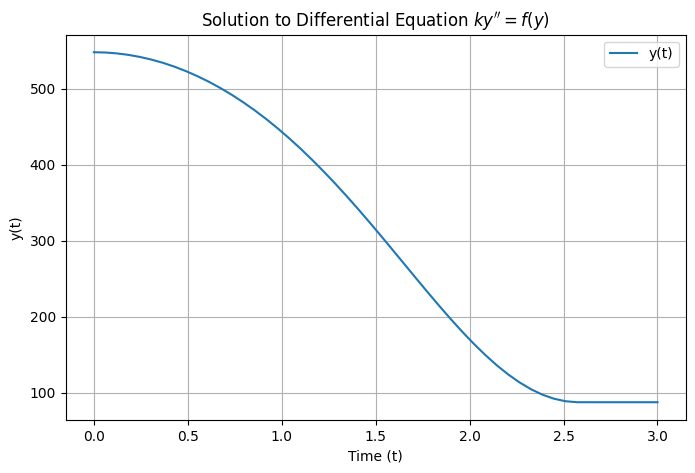

np.float64(84.03013565481025)

In [499]:
R129_Design.returnability(3)

In [430]:
750.53*878/1930

341.43281865284973

In [502]:
R129_Design.camber(30)

np.float64(-3.1823628415324885)

In [33]:
R129_Kerb.left_plus_right_returning_moment(-45)

np.float64(73.34890440190901)

In [30]:
angle = -45
print(angle)
a = R129_Kerb.kpm_circular_dynamic_left(angle)
print(a)
b = R129_Kerb.kpm_circular_dynamic_right(angle)
print(b)
print((a+b)/2)

-45
52.9315677545997
20.41733664730931
36.674452200954505


In [29]:
R129_Kerb.kpi(0)

np.float64(13.972481079116022)

In [489]:
R129_Design.rack_stroke

np.float64(57.37311700884021)

In [424]:
R129_Design.dynamicsolve(-45)

(np.float64(228.938229174948),
 np.float64(157.09603212243974),
 np.float64(258.5630274615422),
 np.float64(105.93271124109022),
 np.float64(3.7022875783256435),
 np.float64(1.48762988821319),
 np.float64(0.35452726915412164),
 np.float64(0.533416541650407),
 np.float64(125.12586901821044),
 np.float64(51.27367643659346),
 np.float64(15.966035544965305),
 np.float64(13.654503911194864),
 (np.float64(7.832061885427072), np.float64(4.504898613311839)))

0.5440378154842974
0.5440378154842974
0.5440378154842974
0.5440378154949024
0.5440378161195082
0.5440378160513382
0.5440378161757651
0.5440378161757651
0.5440378161713334
0.5440378175652919
0.5440378237870935
0.5440378264513239
0.5440378291116652
0.5440378291116652
0.5440378735714466
0.5440379909043478
0.5440386808035069
0.5440388587791801
0.5440391029934248
0.544039103878957
0.5440437435110993
0.544055468490206
0.5441245499052249
0.5441423025920907
0.5441668155622874
0.5441668174065221
0.5446313901811113
0.5458053885902011
0.5541620340524336
0.5558653826385627
0.5583372244708175
0.5583432387264456
0.5818942496126268
0.6158240902778042
0.8194587915282917
0.8722893256666414
0.9444273184784896
0.9454935407966024
1.365402296913851
1.8200621149107397
3.658861827493473
3.68650072051651
3.588504446439633
3.6764126446109544
1.2124478389842295
1.446833148866371
2.712228313279445
2.972442206554484
3.2103501064536952
3.1757987014676594
3.3919595167839978
3.4993390886083904
3.716994794056227
3.71

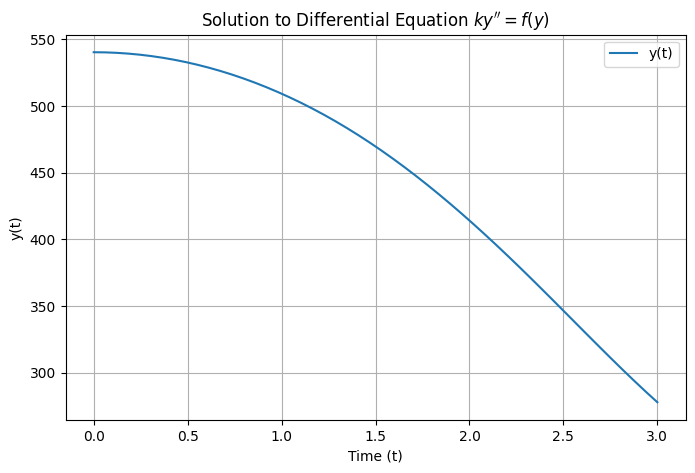

np.float64(48.55550066271334)

In [498]:
R129_Kerb.returnability(3)

In [484]:
R129_Kerb.scrub_radius(0)

np.float64(11.742570023356961)

In [497]:
R129_Kerb.ackerman_vs_KPA(R129_Kerb.KPA_rotation_angle_vs_rack(R129_Kerb.rack_stroke))

np.float64(73.36364718998017)

In [410]:
R129_Design.rack_stroke/(2*np.pi*6)*360

np.float64(559.4361170529638)

In [450]:
R129_Design.rack_stroke

np.float64(57.37311700884021)

In [378]:
R129_Design.caster_trail(0)

np.float64(46.438162773898284)

In [379]:
R129_Design.caster(0)

np.float64(10.388190433508516)

In [380]:
R129_Design.kpi(0)

np.float64(14.837349864123865)

In [381]:
R129_Design.scrub_radius(0)

np.float64(12.913235010835479)

In [300]:
R129_Design.dynamicsolve(-45)

(np.float64(215.05046333988093),
 np.float64(147.2981562037137),
 np.float64(268.14640941406833),
 np.float64(120.03497104236075),
 np.float64(2.806153462972854),
 np.float64(1.9361813123652731),
 np.float64(0.471253295286864),
 np.float64(0.7021684012926188),
 np.float64(100.31974693054208),
 np.float64(60.91266479635956),
 np.float64(21.442911564804703),
 np.float64(20.189634338723714),
 (np.float64(9.369114983044271), np.float64(4.01072302014273)))

In [112]:
QUTE_35L_EV_Design.kpm_circular_dynamic_right(-45)

np.float64(13.025783818319738)

Optimal parameters: y1 = 143.67525708957106, t = 1.788772396121983
Optimal parameters: y1 = 89.84804991268737, t = 1.8829053668857623
Optimal parameters: y1 = 96.10328599917327, t = 1.9708634616351663
Optimal parameters: y1 = 95.19508560127119, t = 2.02587256937772
Optimal parameters: y1 = 39.427827033015845, t = 2.02587256937772
Optimal parameters: y1 = 35.18426464296091, t = 1.9537005688875169
Optimal parameters: y1 = 35.81929162222855, t = 1.978577625898857
Optimal parameters: y1 = 33.56886280920807, t = 1.978577625898857
Optimal parameters: y1 = 31.313709065551, t = 1.9469271609438
Optimal parameters: y1 = 31.453962143974756, t = 1.9582355755406824
Optimal parameters: y1 = 31.627052242108242, t = 1.9582355755406824
Optimal parameters: y1 = 31.09319591942053, t = 1.9402104534081777
Optimal parameters: y1 = 31.10977792306878, t = 1.9443462859632117
Optimal parameters: y1 = 30.97416604198843, t = 1.949516076657004
Optimal parameters: y1 = 31.093779052635377, t = 1.9425703806819428
Opt

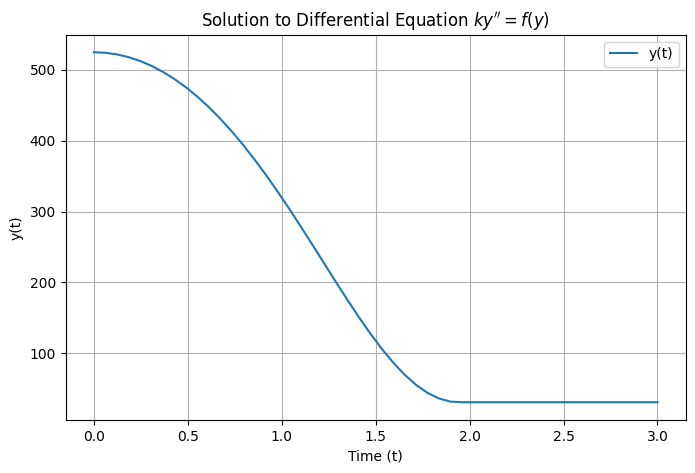

np.float64(94.0754229960547)

In [103]:
QUTE_35L_EV_Design.returnability(3)

In [7]:
QUTE_35L_EV_Homologation = Vehicle(
    np.array([1047.51, 424.19, 1271.36]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.68, 413.41, 1303.77]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.16, 570.00, 992.20]),    # Wheel Centre.
    np.array([987.72, 500.68, 955.80]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    904.76,                                # GVW
    750.03,                                # b, CG from the rear axle
    322.29,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.29, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.14, 401.44, 1283.86]),  # UCA Bush 1
    r_Ub=np.array([1240.14, 497.44, 1283.86])   # UCA Bush 2
)

In [57]:
QUTE_LPG35_Design = Vehicle(
    np.array([1047.43, 424.19, 1272.65]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.60, 413.41, 1305.06]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.44, 20.00, 1316.17]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.12, 570.00, 993.48]),    # Wheel Centre.
    np.array([987.68, 500.68, 957.08]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,                                   # DLR
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    995,                                   # GVW
    692.33,                                # b, CG from the rear axle
    419.75,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81])   # UCA Bush 2
)

Optimal parameters: y1 = 131.89040504447178, t = 2.093043958015384
Optimal parameters: y1 = 325.4519311622441, t = 2.173712379314115
Optimal parameters: y1 = 249.48280822803218, t = 2.274547905937528
Error encountered at theta = -0.5986586025729099: A value (-87.93440570057075) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.6086586025729099
Error encountered at theta = -0.6086586025729099: A value (-88.16888681356909) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.6186586025729099
Error encountered at theta = -0.6186586025729099: A value (-88.40490153734845) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.62865860257291
Error encountered at theta = -0.62865860257291: A value (-88.64252452597924) in x_new is below the interpolation range's minimum value (0).. Retrying with theta = -0.63865860257291
Error encountered at theta = -0.63865860257291: A value (-88.88176

C:\Users\aarora\AppData\Local\Temp\ipykernel_30396\4077541409.py:924: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda x: self.helperrack(x) - val, x0=[guess], xtol=0.01, factor = 5)[0]
C:\Users\aarora\AppData\Local\Temp\ipykernel_30396\4077541409.py:924: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda x: self.helperrack(x) - val, x0=[guess], xtol=0.01, factor = 5)[0]


Optimal parameters: y1 = 33.84317064155907, t = 2.0584864747423954
Optimal parameters: y1 = 33.852650227486656, t = 2.0608909643397815
Optimal parameters: y1 = 33.81971547535786, t = 2.0638965763365142
Optimal parameters: y1 = 33.84513370700172, t = 2.059228607126823
Optimal parameters: y1 = 33.84933005230001, t = 2.0603339176829167
Optimal parameters: y1 = 33.84524093907601, t = 2.0617155558780342
Optimal parameters: y1 = 33.84319027916144, t = 2.0617155558780342
Optimal parameters: y1 = 33.839076552384654, t = 2.0559754480351917
Optimal parameters: y1 = 33.839646014161644, t = 2.056719296469993
Optimal parameters: y1 = 33.83613286736442, t = 2.057649107013495
Optimal parameters: y1 = 33.83926455284007, t = 2.0563086574884863
Optimal parameters: y1 = 33.83956827149379, t = 2.05665571158066
Optimal parameters: y1 = 33.83902980499349, t = 2.0570895291958764
Optimal parameters: y1 = 33.839270886271855, t = 2.0563174603099723
Optimal parameters: y1 = 33.8393943003148, t = 2.05647214128039

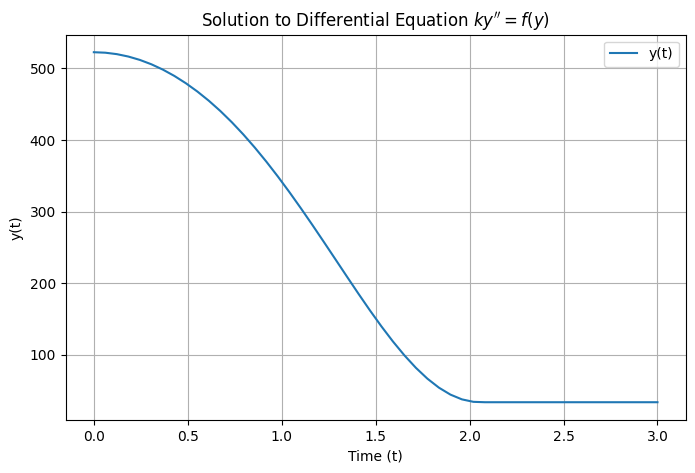

np.float64(93.52244572360708)

In [58]:
QUTE_LPG35_Design.returnability(3)

In [16]:
QUTE_LPG35_Design.road_steer_vs_rack(33/520*53)

np.float64(-2.0914074460136853)

In [14]:
QUTE_LPG35_Design.dynamicsolve(-27.35)

Error encountered at theta = -27.35: index 2012 is out of bounds for axis 0 with size 1001. Retrying with theta = -27.360000000000003


(np.float64(218.73198681000972),
 np.float64(162.09024723813073),
 np.float64(395.0714868870453),
 np.float64(219.106279064808),
 np.float64(2.515603835445891),
 np.float64(1.205209753558253),
 np.float64(0.21343050393504662),
 np.float64(0.27275660094955023),
 np.float64(97.82459159003699),
 np.float64(42.82356144037741),
 np.float64(12.379097004325645),
 np.float64(12.545307686695766),
 (np.float64(7.656020078631909), np.float64(3.0940428103236224)))

In [101]:
QUTE_LPG35_Design.returnability(2.5)

Optimal parameters: y1 = 131.89040504447178, t = 2.093043958015384
Optimal parameters: y1 = 325.4519311622441, t = 2.173712379314115
Optimal parameters: y1 = 249.48280822803218, t = 2.274547905937528


ValueError: A value (-87.93440570057075) in x_new is below the interpolation range's minimum value (0).

Optimal parameters: y1 = 178.00346620009512, t = 2.052498004492704
Optimal parameters: y1 = 110.47030573139912, t = 2.1668997658581572
Optimal parameters: y1 = 58.306100226494834, t = 2.1668997658581572
Optimal parameters: y1 = 57.366770224512685, t = 2.1848241430677455
Optimal parameters: y1 = 54.931656498993576, t = 2.514800878671784
Optimal parameters: y1 = 58.208740585167334, t = 2.19981189669453
Optimal parameters: y1 = 59.6162453663985, t = 2.2171903805389683
Optimal parameters: y1 = 58.53350775170372, t = 2.2389134853445163
Optimal parameters: y1 = 57.88971386135378, t = 2.1995265941744955
Optimal parameters: y1 = 58.179281996581075, t = 2.2072362757586887
Optimal parameters: y1 = 58.12904551243525, t = 2.21687337773893
Optimal parameters: y1 = 58.002915952691744, t = 2.21687337773893
Optimal parameters: y1 = 57.315504778377196, t = 2.172780078920372
Optimal parameters: y1 = 57.38213992769164, t = 2.177517925476329
Optimal parameters: y1 = 57.31491418196586, t = 2.18344023367127

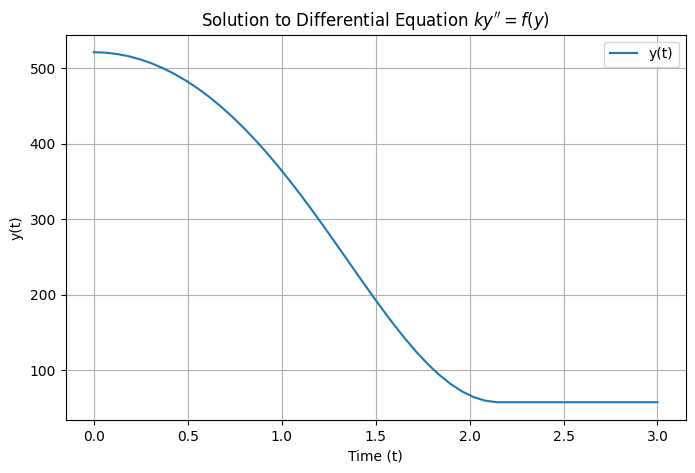

np.float64(89.01965974701204)

In [8]:
QUTE_35L_EV_Homologation.returnability(3)

In [4]:
QUTE_LPG35_Homologation = Vehicle(
    np.array([1048.34, 424.19, 1262.10]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([971.56, 413.37, 1294.62]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.44, 20.00, 1316.17]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.55, 570.00, 983.02]),    # Wheel Centre.
    np.array([988.10, 500.68, 946.63]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    814,                                   # GVW
    678.74,                                # b, CG from the rear axle
    348.14,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81])   # UCA Bush 2
)

In [6]:
angle = -46 
for i in range(4600):
    angle += 0.01
    print(angle)
    QUTE_LPG35_Design.dynamicsolve(angle)

-45.99
-45.980000000000004
-45.970000000000006
-45.96000000000001
-45.95000000000001
-45.94000000000001
-45.930000000000014
-45.920000000000016
-45.91000000000002
-45.90000000000002
-45.89000000000002
-45.880000000000024
-45.870000000000026
-45.86000000000003
-45.85000000000003
-45.84000000000003
-45.830000000000034
-45.820000000000036
-45.81000000000004
-45.80000000000004
-45.79000000000004
-45.780000000000044
-45.770000000000046
-45.76000000000005
-45.75000000000005
-45.74000000000005
-45.730000000000054
-45.720000000000056
-45.71000000000006
-45.70000000000006
-45.69000000000006
-45.680000000000064
-45.670000000000066
-45.66000000000007
-45.65000000000007
-45.64000000000007
-45.630000000000074
-45.620000000000076
-45.61000000000008
-45.60000000000008
-45.59000000000008
-45.580000000000084
-45.570000000000086
-45.56000000000009
-45.55000000000009
-45.54000000000009
-45.53000000000009
-45.520000000000095
-45.5100000000001
-45.5000000000001
-45.4900000000001
-45.4800000000001
-45.47000

KeyboardInterrupt: 

Optimal parameters: y1 = 59.57584324436198, t = 2.1515893772756236
Optimal parameters: y1 = 160.43268887051187, t = 2.4322272704022403
Optimal parameters: y1 = 158.5735285592149, t = 2.5095478803191744
Optimal parameters: y1 = 87.61326867797119, t = 2.5095478803191744
Optimal parameters: y1 = 83.83945093937656, t = 2.411589229645858
Optimal parameters: y1 = 84.87379839200253, t = 2.446761396621099
Optimal parameters: y1 = 81.85282527411218, t = 2.446761396621099
Optimal parameters: y1 = 78.67400340138988, t = 2.3869557681272964
Optimal parameters: y1 = 78.90542993413212, t = 2.3996344779684504
Optimal parameters: y1 = 78.27514382395971, t = 2.4154828652698925
Optimal parameters: y1 = 78.66056571913857, t = 2.392097725249805
Optimal parameters: y1 = 78.72500463266265, t = 2.397986631209948
Optimal parameters: y1 = 78.631182961937, t = 2.405347763660126
Optimal parameters: y1 = 78.6568005308779, t = 2.3920324183651744
Optimal parameters: y1 = 78.6792794408097, t = 2.394646484871676
Optim

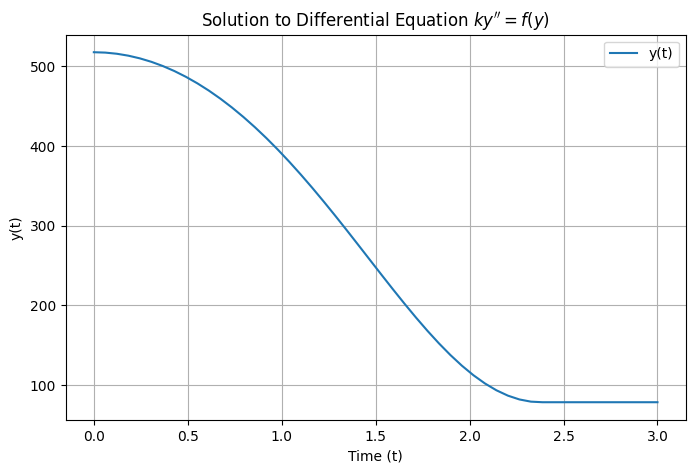

np.float64(84.81425665884763)

In [99]:
QUTE_LPG35_Homologation.returnability(3)

Optimal parameters: y1 = 82.48881803241807, t = 2.8079038288521003
Optimal parameters: y1 = 199.77080310435178, t = 3.0
Optimal parameters: y1 = 150.47054213455382, t = 2.9708414413133952
Optimal parameters: y1 = 150.2519554860008, t = 2.9927103603283487
Optimal parameters: y1 = 149.2891029924393, t = 2.995950200182416
Optimal parameters: y1 = 148.96103583263533, t = 3.0
Optimal parameters: y1 = 150.59315787671477, t = 3.0
Optimal parameters: y1 = 150.4738649440616, t = 2.968292069452747
Optimal parameters: y1 = 150.37495180995208, t = 2.982512872885757
Optimal parameters: y1 = 149.9668339823758, t = 2.984619658579536
Optimal parameters: y1 = 149.82690260501622, t = 2.98725314069676
Optimal parameters: y1 = 150.51707350584732, t = 2.98725314069676
Optimal parameters: y1 = 150.4771953469083, t = 2.9680241427076366
Optimal parameters: y1 = 150.4729076123522, t = 2.978459605194719
Optimal parameters: y1 = 150.47720056487776, t = 2.968134625549038
Optimal parameters: y1 = 150.4772713157337

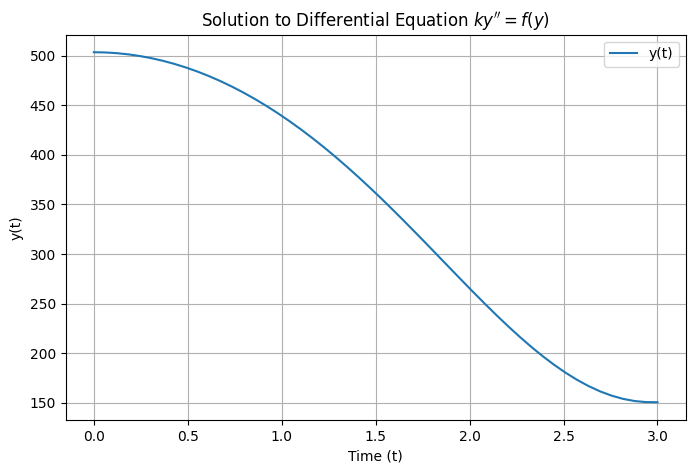

np.float64(70.11718953436042)

In [95]:
QUTE_CNG60_Kerb.returnability(3)

In [50]:
QUTE_CNG35_Kerb.kpm_circular_dynamic_left(-45)

-28.984241331127578


np.float64(18.98551015600016)

In [36]:
QUTE_CNG35_Kerb.caster_trail(0)

np.float64(48.1227863396587)

In [35]:
QUTE_CNG35_Kerb.dynamicsolve(-45)

(np.float64(137.42831618304163),
 np.float64(103.79016749069716),
 np.float64(220.64100730784008),
 np.float64(80.82050901863398),
 np.float64(3.3193577697064844),
 np.float64(1.2162105715149922),
 np.float64(0.36030352432584656),
 np.float64(0.5525892858319849),
 np.float64(85.57257541922706),
 np.float64(33.804020194892765),
 np.float64(16.624575936015216),
 np.float64(15.888737416483414),
 (np.float64(2.1462197102912444), np.float64(1.1005548211882328)))

In [51]:
QUTE_35L_EV_Design = Vehicle(
    np.array([1047.18, 424.19, 1278.59]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.32, 413.43, 1310.96]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.93, 20.67, 1316.84]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.03, 570.00, 999.39]),    # Wheel Centre.
    np.array([987.59, 500.68, 962.99]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    1073.67,                               # GVW
    721.05,                                # b, CG from the rear axle
    395.12,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.29, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.14, 401.44, 1283.86]),  # UCA Bush 1
    r_Ub=np.array([1240.14, 497.44, 1283.86])   # UCA Bush 2
)

In [61]:
QUTE_35L_EV_Design.kpm_circular_dynamic_left(-18)

-50.05221413926063


np.float64(15.612754522365762)

In [63]:
QUTE_35L_EV_Design.dynamicsolve(-18)

(np.float64(227.4248960501643),
 np.float64(186.92757635998154),
 np.float64(391.74474747496424),
 np.float64(267.5727801149011),
 np.float64(1.6371150888887205),
 np.float64(0.9484710217749015),
 np.float64(0.0622399308187246),
 np.float64(0.07300109068138072),
 np.float64(71.1381268326079),
 np.float64(38.706722743567475),
 np.float64(3.6006759542141067),
 np.float64(3.6786888558307136),
 (np.float64(8.149262285761566), np.float64(4.002260369200097)))

In [5]:
QUTE_LPG35_Design = Vehicle(
    np.array([1047.43, 424.19, 1272.65]),  # Upper Ball Joint (UBJ), Top Strut Mount for MacPherson.
    np.array([970.60, 413.41, 1305.06]),   # OBJ of Tie Rod to make AB as Steering Arm.
    np.array([1130.44, 20.00, 1316.17]),   # IBJ of Tie Rod (Rack Vector Definition point) to make BC as Tie Rod.
    np.array([995.12, 570.00, 993.48]),    # Wheel Centre.
    np.array([987.68, 500.68, 957.08]),    # Lower Ball Joint (LBJ) to make KA as Kingpin Axis.
    226,                                   # SLR
    241,                                   # DLR
    0.4,                                   # Initial_Camber
    0.4,                                   # Initial_Toe
    1143,                                  # Track width
    1925,                                  # Wheelbase
    995,                                   # GVW
    692.33,                                # b, CG from the rear axle
    419.75,                                # CG height from the wheel centre
    1.2,                                   # Wheel Rate Front
    3,                                     # Wheel Rate Rear
    220,                                   # Tire Stiffness Front
    220,                                   # Tire Stiffness Rear
    6,                                     # Pinion Radius
    30,                                    # Tire Pressure
    -46,                                   # dila, designed inner lock angle
    np.array([1322.30, 515.20, 965.00]),   # LCA Bush 1
    np.array([1322.30, 262.79, 965.00]),   # LCA Bush 2
    r_Ua=np.array([1240.13, 401.44, 1283.81]),  # UCA Bush 1
    r_Ub=np.array([1240.13, 497.44, 1283.81])   # UCA Bush 2
)

In [93]:
QUTE_LPG35_Design.dynamicsolve(-50)

(np.float64(254.42917879967337),
 np.float64(158.00151012745442),
 np.float64(440.68282387572293),
 np.float64(141.88648719715016),
 np.float64(3.364656360496981),
 np.float64(2.72413936430954),
 np.float64(0.9031645299705602),
 np.float64(1.452975126861775),
 np.float64(131.19489169711883),
 np.float64(79.66851926368332),
 np.float64(54.1326164841495),
 np.float64(44.42179704239848),
 (np.float64(7.4059217877925985), np.float64(2.622047791741023)))

In [86]:
QUTE_LPG35_Design.returnability(3)

Optimal parameters: y1 = 131.89040504447178, t = 2.093043958015384
Optimal parameters: y1 = 325.4519311622441, t = 2.173712379314115
Optimal parameters: y1 = 249.48280822803218, t = 2.274547905937528


ValueError: A value (-87.93440570057075) in x_new is below the interpolation range's minimum value (0).

In [64]:
QUTE_LPG35_Design.dynamicsolve(-18)

(np.float64(203.91721696047625),
 np.float64(165.4467324186437),
 np.float64(372.5431064920898),
 np.float64(253.09294412877264),
 np.float64(1.6317311345480627),
 np.float64(0.920852468794011),
 np.float64(0.06941157328228909),
 np.float64(0.081439045669988),
 np.float64(66.74736228621789),
 np.float64(34.101829399634994),
 np.float64(3.9403417003274552),
 np.float64(4.013334539037981),
 (np.float64(6.936908011245991), np.float64(2.7220865246807073)))

In [62]:
QUTE_LPG35_Design.kpm_circular_dynamic_left(-18)

-44.09447522636061


np.float64(15.830408169903016)

In [74]:
angle = -20
a = QUTE_LPG35_Design.kpm_circular_dynamic_left(angle)
print(a)
b = QUTE_LPG35_Design.kpm_circular_dynamic_right(angle)
print(b)
print((a+b)/2)
print(np.rad2deg((a+b)/2/0.32/2))

-44.8561803916484
18.481692097603016
2.6450300511573985
10.563361074380207
945.6812609918198


In [71]:
print(np.rad2deg(27))

1546.9860468532227


In [75]:
angle = -20
a = QUTE_CNG35_Kerb.kpm_circular_dynamic_left(angle)
print(a)
b = QUTE_CNG35_Kerb.kpm_circular_dynamic_right(angle)
print(b)
print((a+b)/2)
print((a+b)/2/0.32/2)

-25.00495547359237
11.232346331215094
0.6862178979007254
5.95928211455791
9.311378303996733


In [76]:
angle = -20
a = QUTE_35L_EV_Design.kpm_circular_dynamic_left(angle)
print(a)
b = QUTE_35L_EV_Design.kpm_circular_dynamic_right(angle)
print(b)
print((a+b)/2)
print((a+b)/2/0.32/2)

-50.88092619559929
18.40540536682039
3.3526226971521353
10.879014031986262
16.998459424978535


In [20]:
QUTE_LPGcumEV_Design.dynamicsolve(-45)

(np.float64(275.46037387500644),
 np.float64(179.7073319201924),
 np.float64(455.36520700219313),
 np.float64(163.13708720257236),
 np.float64(3.3074710779597365),
 np.float64(1.9825127291449378),
 np.float64(0.6727656455331796),
 np.float64(1.0266638453853913),
 np.float64(145.4460479627088),
 np.float64(74.59895904525165),
 np.float64(41.17706962637561),
 np.float64(37.75385022429552),
 (np.float64(14.686228139858654), np.float64(6.006913396519534)))

In [23]:
QUTE_LPG35_Design.dynamicsolve(-20)

(np.float64(207.1450210969149),
 np.float64(164.61510407517898),
 np.float64(377.62563446488736),
 np.float64(245.61424036301818),
 np.float64(1.803452784059563),
 np.float64(0.9472369334193687),
 np.float64(0.08768362978406798),
 np.float64(0.10477579404853699),
 np.float64(75.69676722730182),
 np.float64(35.2680777049225),
 np.float64(5.002731500018161),
 np.float64(5.095490886002066),
 (np.float64(8.418197295006815), np.float64(2.8600310135041362)))

In [24]:
QUTE_35L_EV_Design.dynamicsolve(-20)

(np.float64(230.80735739421692),
 np.float64(186.07179051019847),
 np.float64(397.01021493117497),
 np.float64(259.78063716441085),
 np.float64(1.808765617737059),
 np.float64(0.979954443194924),
 np.float64(0.0813968278795826),
 np.float64(0.09722827875928827),
 np.float64(80.46369669196166),
 np.float64(40.27178204170454),
 np.float64(4.733074761796393),
 np.float64(4.841369604683541),
 (np.float64(9.722778257229955), np.float64(4.227988313820281)))

In [8]:
QUTE_CNG35_Kerb.returnability(3)

Optimal parameters: y1 = 142.02449685915633, t = 2.334265541792594
Optimal parameters: y1 = 83.00433421384338, t = 2.4794307882896183
Optimal parameters: y1 = 110.97561077748533, t = 2.7206515163594136
Optimal parameters: y1 = 44.78410729229382, t = 2.7432645944515346
Optimal parameters: y1 = 46.820562233589044, t = 2.7753565201450927
Optimal parameters: y1 = 22.49881562693421, t = 2.9358161486128838
Optimal parameters: y1 = -41.33092785574702, t = 2.9643423047849353
Optimal parameters: y1 = -48.3682205788533, t = 3.0
Optimal parameters: y1 = 48.70701362693465, t = 3.0
Optimal parameters: y1 = 44.81371651295656, t = 2.715140299843982
Optimal parameters: y1 = 45.448181510175395, t = 2.733170078233764
Optimal parameters: y1 = 37.72972775660138, t = 2.8233189701826724
Optimal parameters: y1 = 17.575244718691113, t = 2.8393454398624787
Optimal parameters: y1 = 15.344766391408228, t = 2.859378526962236
Optimal parameters: y1 = 45.98539483416783, t = 2.859378526962236


KeyboardInterrupt: 